<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_LH/blob/main/GREMLIN_LH_outline_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_LH

In [ ]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <haobowang@fas.harvard.edu>,<so@g.harvard.edu> and wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer/an apple cider in return.
# --Sergey Ovchinnikov and Haobo Wang
# ------------------------------------------------------------

#log


*   Add AdK protein instead of GA/GB
*   List item



Select tensorflow version for Google Colab

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Load some libraries

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import string
import os
import pandas as pd
import pickle
import scipy.stats
from google.colab import files # download files

import tensorflow.compat.v1 as tf1 # importing functions specific to tensorflow v1
tf1.disable_eager_execution() # disable eager execuation (if using tensorflow v2)

## Utils

In [ ]:
def parse_fasta(filename, a3m=False):
  '''function to parse fasta file'''
  
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))
    
  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if len(line)>0:
      if line[0] == ">":
        header.append(line[1:])
        sequence.append([])
      else:
        if a3m: line = line.translate(rm_lc)
        else: line = line.upper()
        sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  
  return header, sequence

def parse_aln(filename):
  '''function to parse fasta file'''
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    line = line.upper()
    sequence.append(line)
  lines.close()
  
  return sequence

alphabet =  "-ACDEFGHIKLMNPQRSTVWY" 

def mk_msa(seqs):
  '''one hot encode msa'''
  #alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)  
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return msa_ori,np.eye(states)[msa_ori]

In [ ]:
def get_mtx(W):
  '''return L*L matrices given by two body term'''
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W),(1,3)))
  np.fill_diagonal(raw,0)
  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

def get_pair_pssm(msa,msa_weights=None):
  '''input: (number of samples, length, states) = (N, L, K)
  output: (L, K, L, K)'''
  if msa_weights is None:
    msa_weights = np.ones(msa.shape[0])
  msa = msa * np.sqrt(1e-8 + msa_weights)[:,None,None]
  return (np.tensordot(msa,msa, [0,0])/np.sum(msa_weights))

def get_pssm(msa,msa_weights=None):
  if msa_weights is None:
    msa_weights = np.ones(msa.shape[0])  
  return (np.sum(msa*msa_weights[:,None,None],0))/np.sum(msa_weights)


In [ ]:
# caculate the KL divergence, to check how severe the overfitting problem in L2 model.
def moments(a):
  return np.mean(a), np.std(a)

def kl_divergence_gaussians(p,q):

  mu_p, sigma_p = moments(p) 
  mu_q, sigma_q = moments(q)
  r = mu_p - mu_q
  return (np.log(sigma_q) - np.log(sigma_p) 
          -0.5 * (1. - (sigma_p**2 + r**2) / sigma_q**2))

## GREMLIN related

In [ ]:
def tf_cov(x,w=None,do_mean=True):
  '''compute weighted covariance matrix'''
  if w is None:
    num_points = tf.cast(tf.shape(x)[0],tf.float32) - 1.0
    if do_mean:
      x_mean = tf.reduce_mean(x, axis=0, keep_dims=True)
      x = (x - x_mean)
  else:
    num_points = tf.reduce_sum(w) - tf.sqrt(tf.reduce_mean(w))
    if do_mean:
      x_mean = tf.reduce_sum(x * w[:,None], axis=0, keepdims=True) / num_points
      x = (x - x_mean) * tf.sqrt(w[:,None])
    else:
      x = x * tf.sqrt(w[:,None])
  return tf.matmul(tf.transpose(x),x)/num_points

def tf_weights(x_msa, w_lam=0.8, gap_cutoff=0.5):
  '''compute weight for each sequence'''

  x_nongap = tf.cast(tf.reduce_mean(x_msa[:,:,-1],axis=0) < gap_cutoff, tf.float32)
  x_msa_nongap = x_msa * x_nongap[None,:,None]
  x_ln = tf.reduce_sum(x_nongap)
  
  x_pw = tf.tensordot(x_msa_nongap, x_msa_nongap, [[1,2], [1,2]]) / x_ln
  x_cut = tf.cast(x_pw >= w_lam, tf.float32)
  return 1.0/tf.reduce_sum(x_cut,-1)

def tf_apc(x_w,return_raw=False):
  '''Average Product Correction'''

  w_sq = tf.square(x_w)
  x_wi = tf.sqrt(tf.reduce_sum(w_sq, axis=(1,3)) + 1e-8)
  x_wi = x_wi - tf.matrix_band_part(x_wi,0,0)
  x_ap_sum = tf.reduce_sum(x_wi,axis=0)
  x_ap = x_ap_sum[None,:] * x_ap_sum[:,None] / tf.reduce_sum(x_ap_sum)
  x_wip = (x_wi - x_ap) 
  x_wip = x_wip - tf.matrix_band_part(x_wip,0,0)
  if return_raw==True:
    return x_wi,x_wip
  else:
    return x_wip
    
    
def INV_COV(X,W=None,lam_w=4.5,pcc=False,do_mean=True,rm_diag=False):
  tf.reset_default_graph()  
  # check if precomputed weights are provided
  weights_pc = False if W is None else True
  pred, x, w = inv_cov_model(lam_w=lam_w,pcc=pcc,do_mean=do_mean,
                             rm_diag=rm_diag,weights_pc=weights_pc)

  # start session, return predictions
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if W is None:
      return sess.run([pred,w],{x:X})
    else:
      return sess.run(pred,{x:X,w:W})

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
  '''modified adam optimizer'''
  
  if var_list is None: var_list = tf.trainable_variables() 
  gradients = tf.gradients(loss,var_list)
  if b_fix: t = tf.Variable(0.0,"t")
  opt = []
  for n,(x,g) in enumerate(zip(var_list,gradients)):
    if g is not None:
      ini = dict(initializer=tf.zeros_initializer,trainable=False)
      mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
      vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)
      
      mt_tmp = b1*mt+(1-b1)*g
      vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
      lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

      if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

      opt.append(x.assign_add(-lr_tmp * mt_tmp))
      opt.append(vt.assign(vt_tmp))
      opt.append(mt.assign(mt_tmp))
        
  if b_fix: opt.append(t.assign_add(1.0))
  return(tf.group(opt))

def get_H(msa,states=21):
  '''get entropy by given msa'''
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # number of positions

  # compute freq per position
  pssm = np.zeros((msa.shape[1],states))
  for i in range(states):
    idx, counts = np.unique(np.where(msa == i)[1],return_counts=True)
    pssm[idx,i] = counts/msa.shape[0]

  H = -np.sum(pssm * np.log(pssm+1e-9),1)/np.log(states)
  return H
  
def inv_cov(X,
            X_W,
            lam_w=4.5,
            pcc=False,
            do_mean=True,
            rm_diag=False,
            weights_pc=True):
  '''tf version of inverse covariance matrix'''
  # input msa
  x = tf.placeholder(tf.float32,shape=(None,None,None),name="x")

  x_shape = tf.shape(x)
  x_nr = x_shape[0] # num rows
  x_nc = x_shape[1] # num cols
  cat = x_shape[2]
  x_msa = x
  x_feat = tf.reshape(x_msa,(x_nr, x_nc * cat))

  if weights_pc:
    # load precomputed weights for each sequence
    x_weights = tf.placeholder(tf.float32,shape=(None,),name="x_weights")
  else:
    x_weights = tf_weights(x_msa)

  # compute covariance
  x_c = tf_cov(x_feat,x_weights,do_mean=do_mean)

  # add reg
  x_reg_alpha = lam_w/tf.sqrt(tf.reduce_sum(x_weights))
  x_I = tf.eye(x_nc * cat)
  x_c = x_c + x_reg_alpha * x_I

  # compute inverse
  x_c_inv = tf.linalg.inv(x_c)

  if pcc:
    # partial correlation coefficient
    x_c_inv_diag = tf.diag_part(x_c_inv)
    x_w = x_c_inv / tf.sqrt(x_c_inv_diag[None,:] * x_c_inv_diag[:,None])
  elif rm_diag:
    # zero-out diag
    x_w = x_c_inv / tf.diag_part(x_c_inv) - x_I
    x_w = (x_w + tf.transpose(x_w))/2
  else:
    x_w = x_c_inv

  x_w = tf.reshape(-x_w,(x_nc,cat,x_nc,cat))
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    return sess.run(x_w,{x:X,x_weights:X_W})


### GREMLIN

In [ ]:
# encode A
def GREMLIN(msa,
            msa_weights=None, 
            lambda_L2=0.01,     
            opt_iter=400,
            batch_size=100,
            lr = 1.0,
            ignore_gap = False, 
            use_bias = True, 
            reg_mode = "L2",
            lambda_LH = 0.1,
            lambda_LB = 0.005,
            Inv_init = True,
            verbose = False,
            return_raw = True,
            power_iter = True,
            monitering = False,
            param_flag = False):
  '''msa，a 2D np array, mas_weights, weighted sequence to downweights phylogeny effects
    looks like add msa_weights will increase the performance a little bit,same with using bias
  '''

  def reg_LH(w,power_iter = True):
    '''penalize the largest eigenvalue, to make a low-pass filter'''
    raw = tf.sqrt(tf.reduce_sum(tf.square(w),(1,3))+1e-8) 
    ### penalizing by first eigen value
    if power_iter:
      x = tf.reduce_sum(raw,0)
      dominant_eig = tf.einsum('i,ij,j->',x,raw,x)/(1e-8+tf.reduce_sum(tf.square(x)))
    else:
      dominant_eig = tf.linalg.eigvalsh(raw)[-1]
    return tf.square(dominant_eig)/2.0

  def get_gradient(reg,w):
    M = tf.sqrt(tf.reduce_sum(tf.square(w),[1,3])+1e-8)
    g = tf.gradients(reg,w)
    g_m = tf.gradients(M,w)
    g_bob = g[0]/(g_m[0])
    return tf.reduce_mean(g_bob,[1,3])

  if ignore_gap: # sequence gap has some issues in MRF model.
    states = 20
  else:
    states = 21
    
  msa = tf.keras.utils.to_categorical(msa,states)
  
  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence  

    
  # kill any existing tensorflow graph
  tf.reset_default_graph()  
  
  # inputs                
  MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa")
  if ignore_gap:
    non_gap = tf.abs(1.0 - MSA[...,-1]) # to label loss function
    MSA = MSA[...,:-1]
  MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
  
  # msa_weights
  NEFF = tf.reduce_sum(MSA_weights) 
  if msa_weights is None:
    with tf.Session() as sess:
    # initialize
      sess.run(tf.global_variables_initializer())
      msa_weights = sess.run(tf_weights(MSA),{MSA:msa})
    
 
  neff = np.sum(msa_weights) # number of "effective" sequences
  
  # setting up weights
  if use_bias:
    b = tf.get_variable("b", [ncol,states],
                      initializer=tf.initializers.zeros)
  
  if Inv_init:
    Inv = inv_cov(msa,msa_weights)
  else:
    Inv = np.zeros((ncol,states,ncol,states))

  w = tf.get_variable("w", [ncol,states,ncol,states],
                      initializer=tf.constant_initializer(Inv))
    
  # symmetrize w
  one = tf.ones((ncol,ncol))
  one = one - tf.matrix_band_part(one,0,-1)
  
  w = w * one[:,None,:,None]
  w = (w + tf.transpose(w,[2,3,0,1]))/2.0
  w = w - tf.reduce_mean(w,(1,3),keepdims=True) 
   
  
  # dense layer 
  MSA_pred = tf.einsum("ijk,jklm->ilm",MSA,w)
  if use_bias:
    MSA_pred = MSA_pred + b
  
  # softmax activation
  MSA_pred = tf.nn.softmax( MSA_pred ,-1)
  
  
  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.keras.losses.categorical_crossentropy(MSA,MSA_pred)
  if ignore_gap:
    loss = loss * non_gap
              
  loss = tf.reduce_sum(loss, axis=-1)
  loss = tf.reduce_sum(loss * MSA_weights)
  loss = loss/NEFF
  
  #regularizer
  reg_w = 0.0
  if reg_mode == "L2":
    reg_w = 0.5 * lambda_L2 * tf.reduce_sum(tf.square(w)) * ncol *  states/np.sqrt(neff) / np.sqrt(1000)# the proper lambda is 0.01

  elif reg_mode == "LH":
    dominant_eig = reg_LH(w,power_iter=power_iter)
    reg_w = 0.5 * lambda_LH * ncol * states * dominant_eig/np.sqrt(neff) / np.sqrt(1000) # the proper lambda is 0.05-0.1
    #reg_w = 0.5 * lambda_LH * ncol * states * dominant_eig/neff
  elif reg_mode == "LB":
    raw = tf.sqrt(tf.reduce_sum(tf.square(w),(1,3))+1e-8)
    reg_w =  lambda_LB * tf.reduce_sum(raw) * ncol *  states/np.sqrt(neff) / np.sqrt(1000) # the proper lambda is 0.02

  reg = reg_w

  if use_bias: 
    reg_b = 0.5 * lambda_L2 * tf.reduce_sum(tf.square(b)) * ncol * states//np.sqrt(neff) / np.sqrt(1000) 
    reg = reg + reg_b
  
  loss = loss + reg

  def feed(feed_all=False,bs = batch_size):
    if bs is None or feed_all:
      return {MSA:msa, MSA_weights:msa_weights}
    else:
      idx = np.random.randint(0,nrow,size=bs)
      return {MSA:msa[idx], MSA_weights:msa_weights[idx]}
  

  lr = lr# 0.1 * np.log(neff)/ncol
  opt = opt_adam(loss,"adam",lr=lr)
  # optimize
  with tf.Session() as sess:
    # initialize
    sess.run(tf.global_variables_initializer())
    if use_bias:
    # initialize bias
      pc = 0.01 * np.log(neff)
      b_ini = np.log(np.sum(msa.T * msa_weights,-1).T + pc)
      b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
      sess.run(b.assign(b_ini))
    # compute loss across all data
    get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) ,2)

    if monitering:
      performance = []
      #eig_list = []

    for i in range(opt_iter):
      sess.run(opt,feed(bs=batch_size))

      if verbose and (i+1) % int(opt_iter/5) == 0:
        print("iter full_loss,regularizer",(i+1),get_loss(),sess.run(reg,feed(feed_all=True)))

      if monitering:
        raw_apc = sess.run(tf_apc(w, return_raw = return_raw))
        #U = tf.linalg.eigvalsh(raw_apc[0])
        #eig_list.append(sess.run(U))
        gradient_M = sess.run(get_gradient(reg,w))
        performance.append([i,*raw_apc,gradient_M])


    if monitering:
      return performance
    
    raw_apc = sess.run(tf_apc(w,return_raw = return_raw))
      

    if use_bias:
      V = sess.run(b)
    else:
      V = np.zeros((ncol,states))
    W = sess.run(w)
    

  # return the learned weights!
  if not param_flag:
    return raw_apc
  else:
    return V,W

In [ ]:
def get_Hamiltonian_loss(MSA,w,b=False,return_H=False):
  # input         
  #OH_MSA = tf.one_hot(MSA,21)
  #OH_MSA = OH_MSA[:,:,:-1]
  # kill any existing tensorflow graph
  tf1.reset_default_graph()
  MSA = tf.Variable(MSA,name = "msa",trainable=False,dtype=tf.float32)
  W = tf.Variable(w,name = "w",trainable=False,dtype=tf.float32)
  B = tf.Variable(b,name = "b",trainable=False,dtype=tf.float32)
  
  ### compress the states
  VW = tf.einsum("njk,jklm->nlm",MSA,W) +B

  # hamiltonian
  H = - tf.reduce_sum(tf.multiply(MSA,VW),axis=(1,2))
  MSA_pred = tf.nn.softmax(VW,-1)

  # Categorical Cross Entropy
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA,MSA_pred),-1)

  # optimize
  sess =  tf.Session()
  sess.run(tf1.global_variables_initializer())
  if return_H:
    return sess.run(H)
  else:
    return sess.run(loss)

In [ ]:
def get_Hamiltonian(MSA,w,b=False):
  tf1.reset_default_graph()
  MSA = tf.Variable(MSA,name = "msa",trainable=False,dtype=tf.float32)
  W = tf.Variable(w,name = "w",trainable=False,dtype=tf.float32)
  B = tf.Variable(b,name = "b",trainable=False,dtype=tf.float32)
  ### compress the states
  VW = tf.einsum("njk,jklm->nlm",MSA,W) +B
  VW = tf.nn.softmax(VW,-1)
  # optimize
  sess =  tf.Session()
  sess.run(tf1.global_variables_initializer())
  return sess.run(VW)

###Utils about results

In [ ]:
def get_acc(pred,true,sub_ln):
  pred_true = np.stack((pred,true),-1)
  pred_true = pred_true[pred_true[:,0].argsort()[::-1]]
  acc = []
  for n in range(10):
    N = int(sub_ln * (n+1)/10)
    acc.append(np.mean(pred_true[:N,1]))
  return np.array(acc)

In [ ]:
def load_real_contacts(gene_name):  
  cst_file = open(f"{gene_name}.dist",'r')
  cst_pd = np.array(pd.read_csv(cst_file,sep=' ',header=None,usecols=[0,2,4]))
  ref_file = open(f"{gene_name}.mtx_ref",'r').readlines()
  ori_seq_ = ref_file[0].strip()
  ref_seq_ = ref_file[1].strip()
  ###calculate the length of sequence been used
  gap_dict = {}
  ncol = 0
  for i,AA in enumerate(ref_seq_):
    if AA != "-":
      gap_dict[i] = ncol
      ncol = ncol + 1
  cst_np=list()
  for line in cst_pd:
    index_i = int(line[0])
    index_j = int(line[1])
    AA_i = ref_seq_[index_i]
    AA_j = ref_seq_[index_j]
    if AA_i!="-" and AA_j !="-" and index_i >=0 and index_j>=0:
      cst_np.append([gap_dict[index_i],gap_dict[index_j],line[2]])   
  return  np.array(cst_np),ncol,gap_dict

##Overfiting issue

### load example

In [ ]:
!wget -q -nc https://raw.githubusercontent.com/whbpt/examples/master/3CNBA.zip

In [ ]:
!unzip 3CNBA.zip <<N

/bin/bash: warning: here-document at line 0 delimited by end-of-file (wanted `N')
Archive:  3CNBA.zip
  inflating: 3CNBA.mtx_ref           
  inflating: 3CNBA.pdb               
  inflating: 3CNBA.mtx               
  inflating: 3CNBA.dist              
  inflating: 3CNBA.a3m.gz            
  inflating: 3CNBA.aln               


In [ ]:
seqs = parse_aln("3CNBA.aln")
msa_ori,msa = mk_msa(seqs)
query_msa = msa[0]
print(msa.shape)
N,L,A = msa.shape

(25947, 120, 21)


### what is APC?

In [ ]:
def get_ap(raw):
  return np.sum(raw,0)

def get_first_eig(raw):
  U = np.linalg.eigvalsh(raw)
  return np.square(U[-1])/np.sum(np.square(U))

In [ ]:
seqs = parse_aln("3CNBA.aln")
msa_ori,msa = mk_msa(seqs)
query_msa = msa[0]
print(msa.shape)
N,L,A = msa.shape

(25947, 120, 21)


In [ ]:
result = list()
(N,L,A) = msa.shape
for i in  range(1,10,1):
  i = i/10
  
  shuffle_idx = np.random.permutation(np.arange(N))
  train_idx = shuffle_idx[:int(i*N)]
  test_idx = shuffle_idx[int(i*N):]
  V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)

  Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
  Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)

  raw = np.sqrt(np.sum(np.square(W_L2),(1,3)))
  ap = np.sum(raw,0)
  ent = get_H(msa_ori[train_idx])
  eig = get_first_eig(raw)

  result.append([int(i*N),scipy.stats.pearsonr(ap,ent)[0],kl_divergence_gaussians(Test_Loss_L2,Train_Loss_L2),eig])

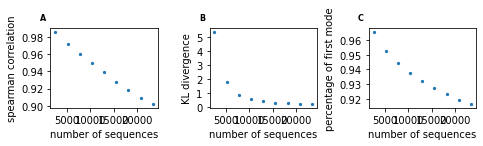

In [ ]:
result = np.array(result)

fig = plt.figure(figsize=(6.75,6.75*0.3),facecolor="white",)
gs = fig.add_gridspec(1, 3)
axes = [fig.add_subplot(gs[i]) for i in range(3)]
plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 
fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=8, weight='bold')

axes[0].scatter(result[:,0],result[:,1],s=5)
axes[0].set_xlabel("number of sequences")
axes[0].set_ylabel("spearman correlation")

axes[1].scatter(result[:,0],result[:,2], s=5)
axes[1].set_xlabel("number of sequences")
axes[1].set_ylabel("KL divergence")


axes[2].scatter(result[:,0],result[:,3], s=5)
axes[2].set_xlabel("number of sequences")
axes[2].set_ylabel("percentage of first mode")


plt.tight_layout()
plt.savefig("APC_signal.pdf")

In [ ]:
# split the training set and test set into 80%:20%
shuffle_idx = np.random.permutation(np.arange(N))
N_cut = int(0.8*N)
train_idx = shuffle_idx[:N_cut]
test_idx = shuffle_idx[N_cut:]
print(f"There are {N_cut} sequences are alloquated in training set, and rest in testing set")

There are 20757 sequences are alloquated in training set, and rest in testing set


In [ ]:
def generate_msa_null(msa,nn=False):
  ## generate a negative sample with same pssm but no coevolution
  msa_null = []
  alphabet = np.arange(A)
  for n in range(L):  
    a = alphabet
    p = np.mean(msa,0)[n]
    if nn:
      c = np.random.choice(a,N)
    else:
      c = np.random.choice(a,N,p=p)
    msa_null.append(c)
  msa_null = np.array(msa_null).T
  msa_null = tf.keras.utils.to_categorical(msa_null,A)
  return msa_null
msa_null = generate_msa_null(msa[train_idx])
msa_null_null = generate_msa_null(msa[train_idx],nn=True)

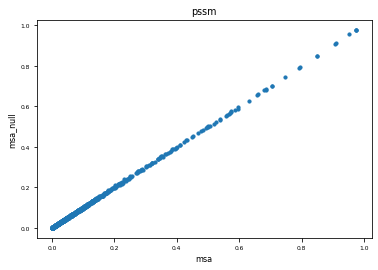

In [ ]:
## check pssm is the same with real msa
plt.scatter(np.mean(msa,0),np.mean(msa_null,0),s=10)
plt.xlabel("msa")
plt.ylabel("msa_null")
plt.title("pssm")
plt.show()

### different regularizers

In [ ]:
train_idx = shuffle_idx[:5000]

In [ ]:
###L2
V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)

In [ ]:
Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)
Null_Loss_L2 = get_Hamiltonian_loss(msa_null,W_L2,V_L2)
Null_null_Loss_L2 = get_Hamiltonian_loss(msa_null_null,W_L2,V_L2)

In [ ]:
###LH
V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True)

In [ ]:
Train_Loss_LH = get_Hamiltonian_loss(msa[train_idx],W_LH,V_LH)
Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH)
Null_Loss_LH = get_Hamiltonian_loss(msa_null,W_LH,V_LH)
Null_null_Loss_LH = get_Hamiltonian_loss(msa_null_null,W_LH,V_LH)

In [ ]:
###block L1(LB)
V_LB,W_LB = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True,Inv_init=False)

In [ ]:
Train_Loss_LB = get_Hamiltonian_loss(msa[train_idx],W_LB,V_LB)
Test_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB)
Null_Loss_LB = get_Hamiltonian_loss(msa_null,W_LB,V_LB)
Null_null_Loss_LB = get_Hamiltonian_loss(msa_null_null,W_LB,V_LB)

## Gradient **differences**

In [ ]:
L2_performance = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True,monitering=True,verbose=True,opt_iter=100)
LH_performance = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True,monitering=True,verbose=True,opt_iter=100)
LB_performance = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True,monitering=True,verbose=True,opt_iter=100)

iter full_loss,regularizer 20 226.59 68.627945
iter full_loss,regularizer 40 222.38 71.23224
iter full_loss,regularizer 60 219.8 72.7632
iter full_loss,regularizer 80 218.01 73.58952
iter full_loss,regularizer 100 216.69 74.14098
iter full_loss,regularizer 20 263.67 90.589005
iter full_loss,regularizer 40 257.55 81.86182
iter full_loss,regularizer 60 254.1 77.34273
iter full_loss,regularizer 80 252.6 75.38481
iter full_loss,regularizer 100 251.19 74.12736
iter full_loss,regularizer 20 245.1 86.21944
iter full_loss,regularizer 40 240.31 87.99334
iter full_loss,regularizer 60 237.63 89.2732
iter full_loss,regularizer 80 235.3 89.923874
iter full_loss,regularizer 100 233.67 90.510925


### summary


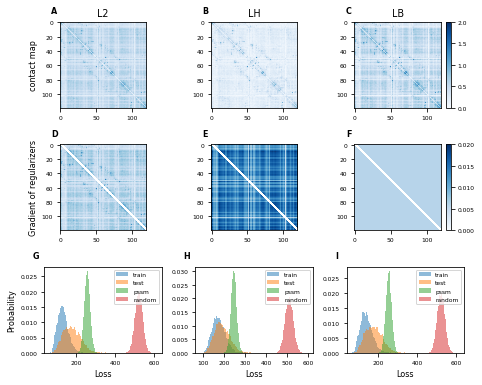

In [ ]:
fig = plt.figure(figsize=(6.75,6.75*0.8),facecolor="white")
gs = fig.add_gridspec(3, 3)
axes = [fig.add_subplot(gs[i]) for i in range(9)]

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=8, weight='bold')

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 
fig.canvas.draw()
#plt.subplot(331)
Gradient_M = L2_performance[99][3]
raw = L2_performance[99][1]
axes[0].set_title("L2")
axes[0].imshow(raw,vmin=0,vmax=2,cmap="Blues")
axes[0].set_ylabel("contact map")
#plt.colorbar()
#plt.subplot(334)
axes[3].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
axes[3].set_ylabel("Gradient of regularizers")
#plt.colorbar()
#plt.subplot(337)
axes[6].hist(Train_Loss_L2,bins=50,density=True,alpha=0.5,label="train")
axes[6].hist(Test_Loss_L2,bins=50,density=True,alpha=0.5,label="test")
axes[6].hist(Null_Loss_L2,bins=50,density=True,alpha=0.5,label="pssm")
axes[6].hist(Null_null_Loss_L2,bins=50,label="random",alpha=0.5,density=True)
#plt.xlabel("Hamiltonian")
axes[6].set_xlabel("Loss")
axes[6].set_ylabel("Probability")
axes[6].legend(prop={'size': 6})


#plt.subplot(332)
Gradient_M = LH_performance[99][3]
raw = LH_performance[99][1]
axes[1].set_title("LH")
axes[1].imshow(raw,vmin=0,vmax=2,cmap="Blues")
#plt.ylabel("M")
#plt.colorbar()
#plt.subplot(335)
axes[4].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
#plt.ylabel("Gradient of regularizers")
#plt.colorbar()
M, apc = get_mtx(W_LB)
#plt.subplot(338)

axes[7].hist(Train_Loss_LH,bins=50,density=True,alpha=0.5,label="train")
axes[7].hist(Test_Loss_LH,bins=50,density=True,alpha=0.5,label="test")
axes[7].hist(Null_Loss_LH,bins=50,density=True,alpha=0.5,label="pssm")
axes[7].hist(Null_null_Loss_LH,bins=50,label="random",alpha=0.5,density=True)
axes[7].set_xlabel("Loss")
#plt.ylabel("Probability")
axes[7].legend(prop={'size': 6})


Gradient_M = LB_performance[99][3]
raw = LB_performance[99][1]
axes[2].set_title("LB")
im2 = axes[2].imshow(raw,vmin=0,vmax=2,cmap="Blues")
#plt.ylabel("M")
fig.colorbar(im2,ax= axes[2])
#plt.subplot(336)
im5 = axes[5].imshow(Gradient_M,vmin=0,vmax=0.02,cmap="Blues")
#plt.ylabel("Gradient of regularizers")
fig.colorbar(im5,ax= axes[5])
#plt.subplot(339)
axes[8].hist(Train_Loss_LB,bins=50,density=True,alpha=0.5,label="train")
axes[8].hist(Test_Loss_LB,bins=50,density=True,alpha=0.5,label="test")
axes[8].hist(Null_Loss_LB,bins=50,density=True,alpha=0.5,label="pssm")
axes[8].hist(Null_null_Loss_LB,bins=50,label="random",alpha=0.5,density=True)
axes[8].set_xlabel("Loss")
##plt.ylabel("Probability")
axes[8].legend(prop={'size': 6})

plt.tight_layout()
plt.savefig("Figure2.pdf")


## Robustness

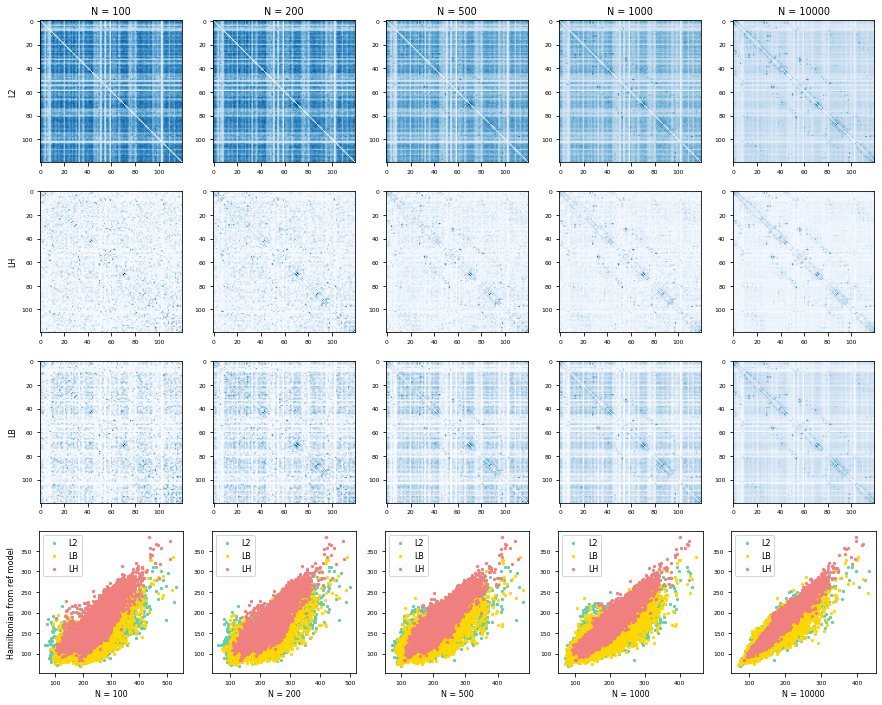

In [ ]:
result = list()
result_kl = list()
(N,L,A) = msa.shape
plt.figure(figsize=(15,12),facecolor="white")

return_H = False
V_L2_ref,W_L2_ref = GREMLIN(msa_ori,reg_mode="L2",param_flag=True)
V_LH_ref,W_LH_ref = GREMLIN(msa_ori,reg_mode="LH",param_flag=True)
V_LB_ref,W_LB_ref = GREMLIN(msa_ori,reg_mode="LB",param_flag=True)

shuffle_idx = np.random.permutation(np.arange(N))
test_idx = shuffle_idx[10000:]

for n,i in  enumerate([100,200,500,1000,10000]):
  
  train_idx = shuffle_idx[:i]

  ####L2
  V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)
  Train_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2,return_H=return_H)
  Train_Loss_L2_ref = get_Hamiltonian_loss(msa[test_idx],W_L2_ref,V_L2_ref,return_H=return_H)

  ####LH
  V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True)
  Train_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH,return_H=return_H)
  Train_Loss_LH_ref = get_Hamiltonian_loss(msa[test_idx],W_LH_ref,V_LH_ref,return_H=return_H)

  ####LB
  V_LB,W_LB = GREMLIN(msa_ori[train_idx],reg_mode="LB",param_flag=True)
  Train_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB,return_H=return_H)
  Train_Loss_LB_ref = get_Hamiltonian_loss(msa[test_idx],W_LB_ref,V_LB_ref,return_H=return_H)


  plt.subplot(4,5,n+1)
  if n ==0:
    plt.ylabel("L2")
  plt.title(f"N = {i}")
  raw,apc = get_mtx(W_L2)
  plt.imshow(raw,cmap="Blues")
  plt.subplot(4,5,n+6)
  if n ==0:
    plt.ylabel("LH")
  raw,apc = get_mtx(W_LH)
  plt.imshow(raw,cmap="Blues")
  plt.subplot(4,5,n+11)
  if n ==0:
    plt.ylabel("LB")
  raw,apc = get_mtx(W_LB)
  plt.imshow(raw,cmap="Blues")

  plt.subplot(4,5,n+16)

  Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2,return_H=return_H)
  Test_Loss_L2_ref = get_Hamiltonian_loss(msa[test_idx],W_L2_ref,V_L2_ref,return_H=return_H)
  
  Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH,return_H=return_H)
  Test_Loss_LH_ref = get_Hamiltonian_loss(msa[test_idx],W_LH_ref,V_LH_ref,return_H=return_H)

  Test_Loss_LB = get_Hamiltonian_loss(msa[test_idx],W_LB,V_LB,return_H=return_H)
  Test_Loss_LB_ref = get_Hamiltonian_loss(msa[test_idx],W_LB_ref,V_LB_ref,return_H=return_H)

  plt.scatter(Test_Loss_L2,Test_Loss_L2_ref,s=5,c="mediumaquamarine",label="L2")
  plt.scatter(Test_Loss_LB,Test_Loss_LB_ref,s=5,c="gold",label="LB")
  plt.scatter(Test_Loss_LH,Test_Loss_LH_ref,s=5,c="lightcoral",label="LH")

  if n ==0:
    plt.ylabel("Hamiltonian from ref model")
  plt.xlabel(f"N = {i}")
  plt.legend()


  result.append([i,Train_Loss_L2,Train_Loss_L2_ref,Train_Loss_LH,Train_Loss_LH_ref,Train_Loss_LB,Train_Loss_LB_ref])
  result_kl.append([i,
                    kl_divergence_gaussians(Test_Loss_L2,Train_Loss_L2),
                    kl_divergence_gaussians(Test_Loss_LH,Train_Loss_LH),
                    kl_divergence_gaussians(Test_Loss_LH,Train_Loss_LB)
                    ])

plt.savefig("Hamiltonian_sequence.pdf")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


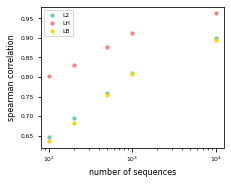

In [ ]:
plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 


result = np.array(result)
tmp = []
for i in range(5):
  # try spearmanr next time
  tmp.append([result[i,0],
              scipy.stats.spearmanr(result[i,1],result[i,2])[0],
              scipy.stats.spearmanr(result[i,3],result[i,4])[0],
              scipy.stats.spearmanr(result[i,5],result[i,6])[0]])
tmp = np.array(tmp)
plt.scatter(tmp[:,0],tmp[:,1],c="mediumaquamarine",s=10,label="L2")
plt.scatter(tmp[:,0],tmp[:,2],c="lightcoral",s=10,label="LH")
plt.scatter(tmp[:,0],tmp[:,3],c="gold",s=10,label="LB")
plt.xticks(np.arange(5), [100,200,500,1000,10000])
plt.xscale("log")
plt.xlabel("number of sequences")
plt.ylabel("spearman correlation")
plt.legend(prop={'size': 6})
plt.tight_layout()
plt.savefig("/content/spearman_sequence.pdf")

#### conclusion

from the pearson correlation side, we can see that the Hamiltonian term from low quality MSA is more correlated with the Hamiltonian term from the ref model, which means LH is better than L2 in ranking sequence energy. From the KL divergence side, this measurement showed the statistical distribution of training and test set, and we can see that LH has lower KL divergence compared to L2, which means the system is less overfitting!

### PCA analysis of W matrix
 show potential probability of encoding the pairwise pssm

In [ ]:
MTX_LH = W_LH.transpose([0,2,1,3]).reshape(L*L,-1)
MTX_LB = W_LB.transpose([0,2,1,3]).reshape(L*L,-1)
MTX_L2 = W_L2.transpose([0,2,1,3]).reshape(L*L,-1)

In [ ]:
tmp = np.ones((L,L))
tmp[np.tril_indices(L)] = 0
idx = np.where(tmp.flatten()==0)
MTX_top_LH = MTX_LH[idx]
MTX_top_LB = MTX_LB[idx]
MTX_top_L2 = MTX_L2[idx]

In [ ]:
U_LH,S_LH = np.linalg.eigh(MTX_top_LH.T@MTX_top_LH)
U_L2,S_L2 = np.linalg.eigh(MTX_top_L2.T@MTX_top_L2)
U_LB,S_LB = np.linalg.eigh(MTX_top_LB.T@MTX_top_LB)

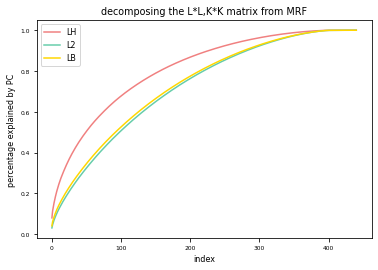

In [ ]:
plt.figure(facecolor="white")
plt.plot(np.cumsum(U_LH[::-1])/np.sum(U_LH),c="lightcoral",label="LH")
plt.plot(np.cumsum(U_L2[::-1])/np.sum(U_L2),c="mediumaquamarine",label="L2")
plt.plot(np.cumsum(U_LB[::-1])/np.sum(U_LB),c="gold",label="LB")
plt.legend()
plt.xlabel("index")
plt.title("decomposing the L*L,K*K matrix from MRF")
plt.ylabel("percentage explained by PC")
plt.savefig("/content/PCA.pdf")

### try more examples
9 different proteins with different number of sequences with be chosen.

In [ ]:
#!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3QHPA.fas
#!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3OIOA.fas
#!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3CNBA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/5CYVA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3BDIA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2R1JL.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2PR7A.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4WPGA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/3RJUA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2HFSA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/2H8GA.fas
!wget -nc -q https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/1ITVA.fas

In [ ]:
name_list = ["5CYVA","3BDIA","2R1JL","2PR7A","4WPGA","3RJUA","2HFSA","2H8GA","1ITVA"]
protein_list = []
for name in name_list:
  msa_dict = {}
  ###making MSA
  names,seqs = parse_fasta(f"{name}.fas")
  msa_ori,msa = mk_msa(seqs)
  msa_dict["msa_ori"] = msa_ori
  #split training set and test set
  (N,L,A) = msa.shape
  shuffle_idx = np.random.permutation(np.arange(N))
  train_idx = shuffle_idx[:int(0.8*N)]
  test_idx = shuffle_idx[int(0.8*N):]
  # generating null sequence 
  msa_null = generate_msa_null(msa[train_idx])
  msa_null_null = generate_msa_null(msa[train_idx],nn=True)

  #L2
  V_L2,W_L2 = GREMLIN(msa_ori[train_idx],reg_mode="L2",param_flag=True)
  Train_Loss_L2 = get_Hamiltonian_loss(msa[train_idx],W_L2,V_L2)
  Test_Loss_L2 = get_Hamiltonian_loss(msa[test_idx],W_L2,V_L2)
  Null_Loss_L2 = get_Hamiltonian_loss(msa_null,W_L2,V_L2)
  Null_null_Loss_L2 = get_Hamiltonian_loss(msa_null_null,W_L2,V_L2)
  msa_dict["Train_Loss_L2"] = Train_Loss_L2
  msa_dict["Test_Loss_L2"] = Test_Loss_L2
  msa_dict["Null_Loss_L2"] = Null_Loss_L2
  msa_dict["Null_null_Loss_L2"] = Null_null_Loss_L2

  raw, apc = get_mtx(W_L2)
  msa_dict["raw_L2"] = raw
  #LH
  V_LH,W_LH = GREMLIN(msa_ori[train_idx],reg_mode="LH",param_flag=True)
  Train_Loss_LH = get_Hamiltonian_loss(msa[train_idx],W_LH,V_LH)
  Test_Loss_LH = get_Hamiltonian_loss(msa[test_idx],W_LH,V_LH)
  Null_Loss_LH = get_Hamiltonian_loss(msa_null,W_LH,V_LH)
  Null_null_Loss_LH = get_Hamiltonian_loss(msa_null_null,W_LH,V_LH)

  msa_dict["Train_Loss_LH"] = Train_Loss_LH
  msa_dict["Test_Loss_LH"] = Test_Loss_LH
  msa_dict["Null_Loss_LH"] = Null_Loss_LH
  msa_dict["Null_null_Loss_LH"] = Null_null_Loss_LH
  raw, apc = get_mtx(W_LH)
  msa_dict["raw_LH"] = raw

  protein_list.append(msa_dict)

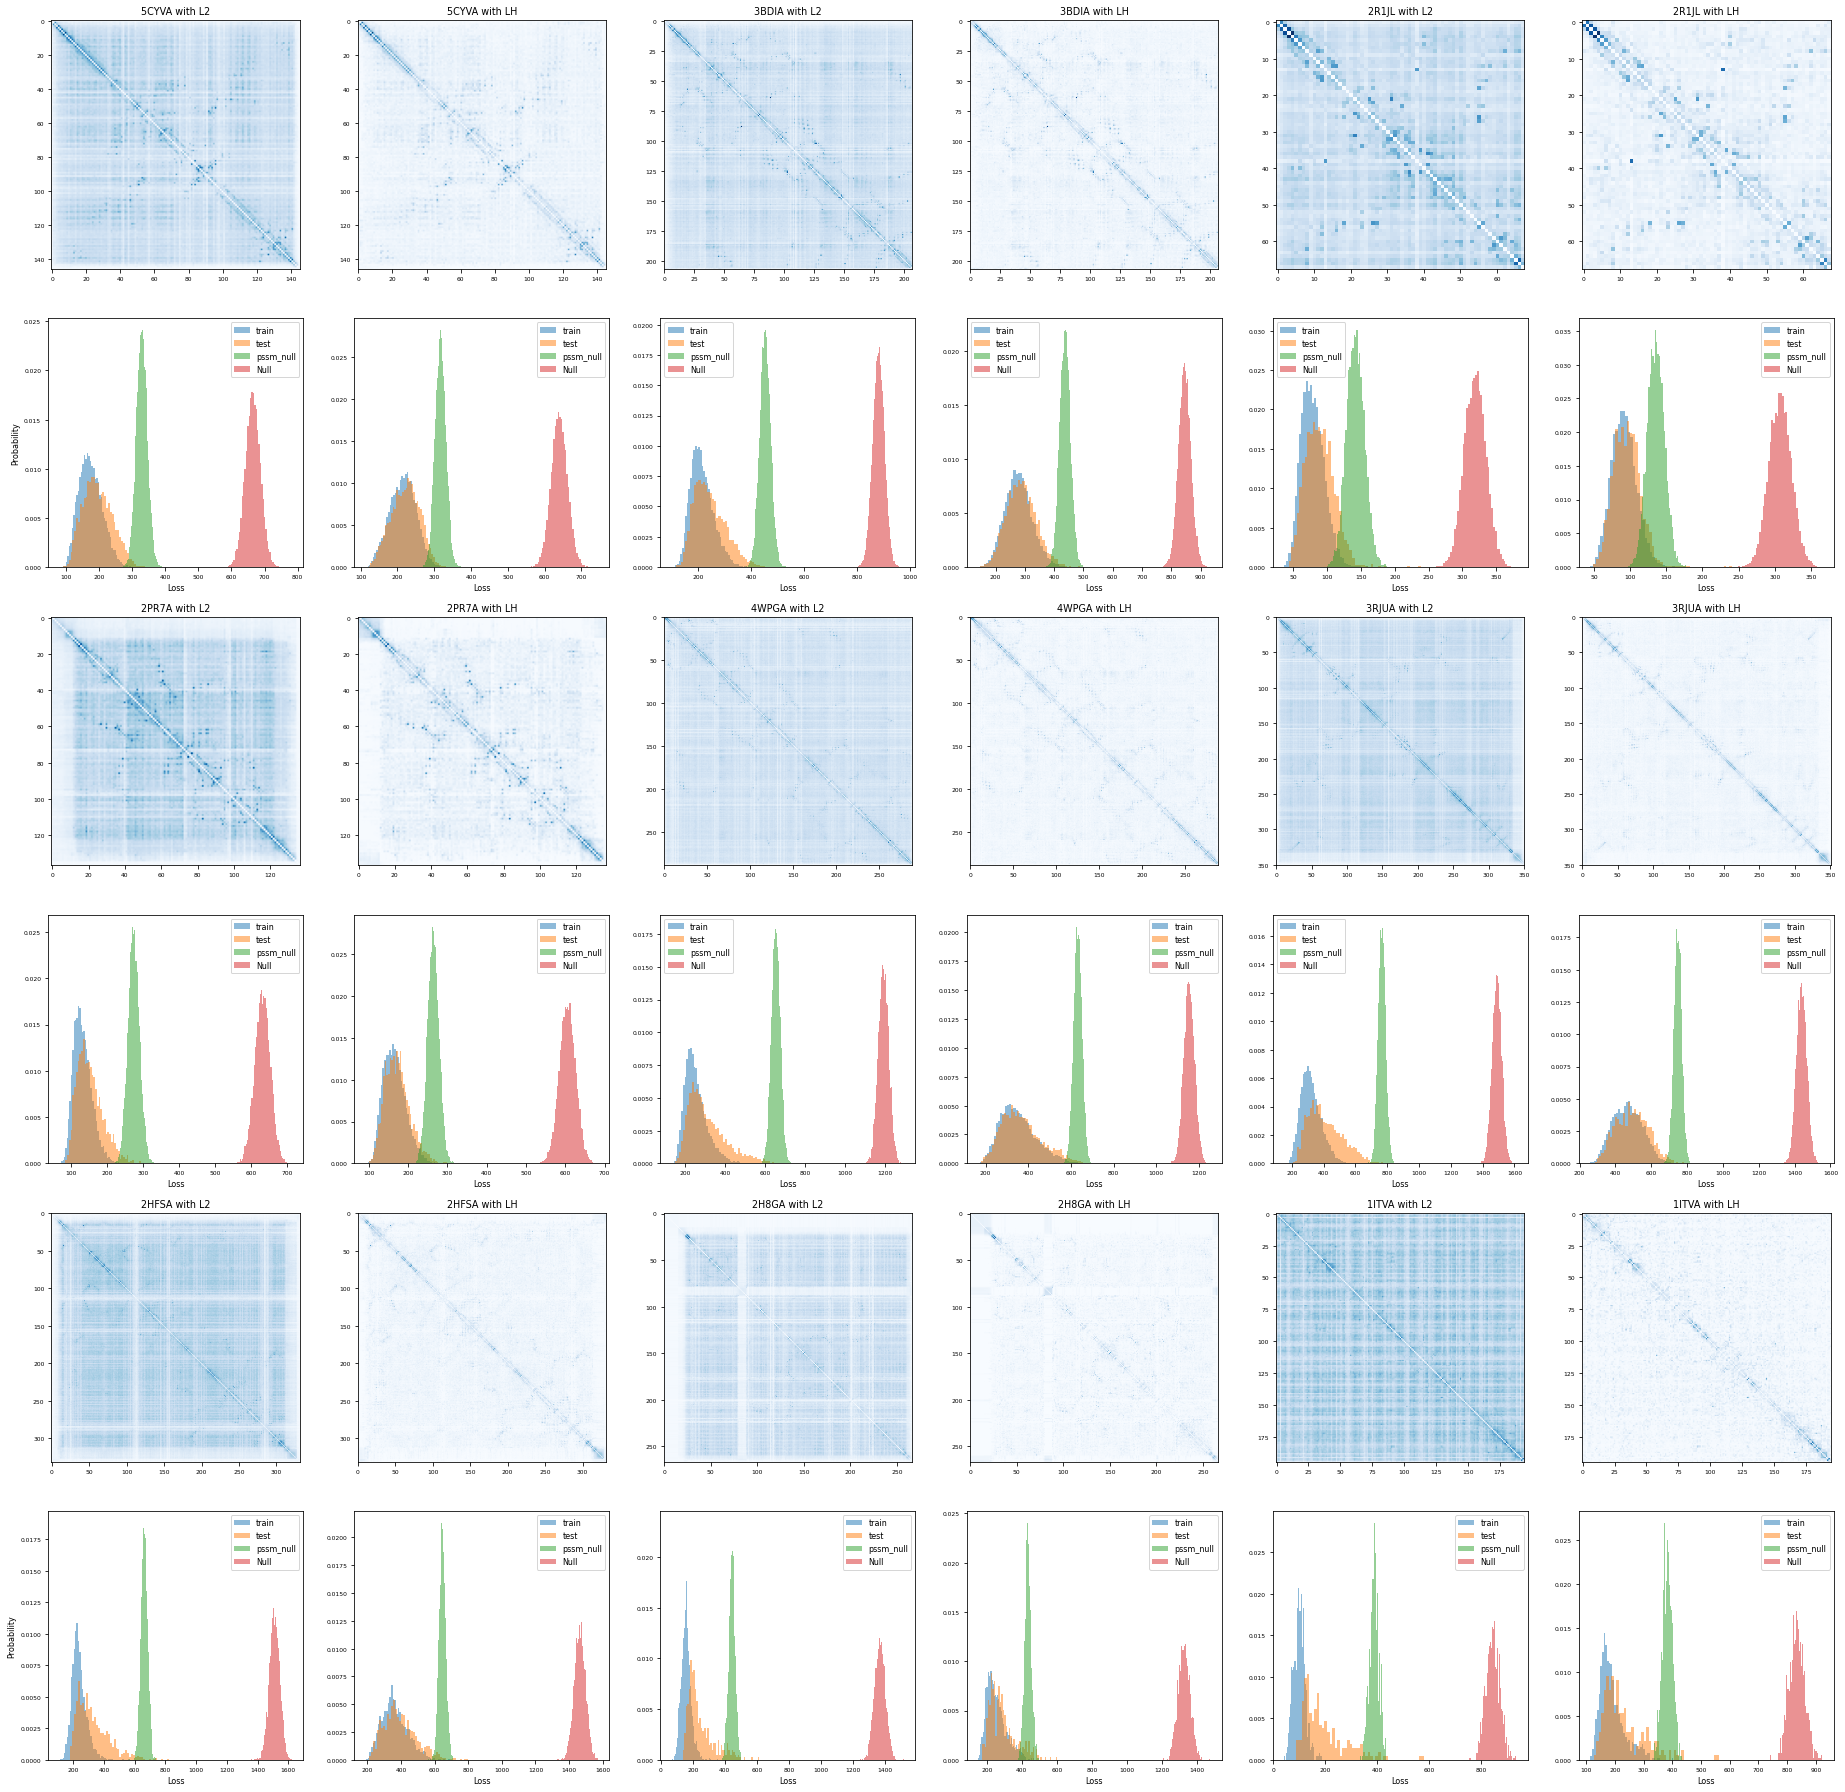

In [ ]:
#fix the x and y axis
plt.figure(figsize=(32,32),facecolor="white")

for i,msa_dict in enumerate(protein_list):

  Train_Loss_L2 = msa_dict["Train_Loss_L2"] 
  Test_Loss_L2 = msa_dict["Test_Loss_L2"]
  Null_Loss_L2 =msa_dict["Null_Loss_L2"] 
  Null_null_Loss_L2 = msa_dict["Null_null_Loss_L2"] 
  raw_L2 = msa_dict["raw_L2"]

  Train_Loss_LH = msa_dict["Train_Loss_LH"] 
  Test_Loss_LH = msa_dict["Test_Loss_LH"]
  Null_Loss_LH =msa_dict["Null_Loss_LH"] 
  Null_null_Loss_LH = msa_dict["Null_null_Loss_LH"] 
  raw_LH = msa_dict["raw_LH"]

  plt.subplot(6,6,i*2+1 + 6*(i//3))
  plt.imshow(raw_L2,cmap="Blues")
  plt.grid(False)
  plt.title(f"{name_list[i]} with L2")
  plt.subplot(6,6,i*2+2+ 6*(i//3))
  plt.imshow(raw_LH,cmap="Blues")
  plt.grid(False)
  plt.title(f"{name_list[i]} with LH")
  plt.subplot(6,6,i*2+7+ 6*(i//3))
  #plt.title("L2")
  plt.xlabel("loss")
  if i%6==0:
    plt.ylabel("Probability")
  plt.hist(Train_Loss_L2,bins=50,density=True,alpha=0.5,label="train")
  plt.hist(Test_Loss_L2,bins=50,density=True,alpha=0.5,label="test")
  plt.hist(Null_Loss_L2,bins=50,density=True,alpha=0.5,label="pssm_null")
  plt.hist(Null_null_Loss_L2,bins=50,label="Null",alpha=0.5,density=True)
  plt.xlabel("Loss")
  plt.legend()
  plt.subplot(6,6,i*2+8+ 6*(i//3))
  #plt.title("LH")
  plt.hist(Train_Loss_LH,bins=50,density=True,alpha=0.5,label="train")
  plt.hist(Test_Loss_LH,bins=50,density=True,alpha=0.5,label="test")
  plt.hist(Null_Loss_LH,bins=50,density=True,alpha=0.5,label="pssm_null")
  plt.hist(Null_null_Loss_LH,bins=50,label="Null",alpha=0.5,density=True)
  plt.xlabel("Loss")
  plt.legend()

plt.savefig("SI-1.pdf")

## contact map 
 this part takes some time to run, so I saved all the results in my google drive!

### load drive

In [ ]:
if os.getcwd()!="/home/whbpt/regal":
  from google.colab import drive
  drive.mount('/gdrive')
  os.chdir('/gdrive/My Drive')

Mounted at /gdrive


In [ ]:
!mkdir GREMLIN_LH
%cd GREMLIN_LH

mkdir: cannot create directory ‘GREMLIN_LH’: File exists
/gdrive/My Drive/GREMLIN_LH


In [ ]:
%%bash 
wget -nc -q https://github.com/sokrypton/seqmodels/raw/master/data.pickle.npy.gz
if [ ! -f data.pickle.npy ];then
  gunzip data.pickle.npy.gz
fi

In [ ]:
data = list(np.load("data.pickle.npy",allow_pickle=True))

In [ ]:
def get_AUC(state_folder,data=data,redo=False):
  ACC_apc = []
  Ref_file = f"{state_folder}.pkl"
  if (not os.path.isfile(Ref_file) ) or redo :

    for n,a in enumerate(data):
      sub_ln = np.sum((np.sum(a["x_mask"],axis=-1) > 0))
      idx = np.triu_indices_from(a["x_true"],k=6)
      mask = np.where(a["x_mask"][idx] > 0)
      true = a["x_true"]
      try:
        acc_apc = []
        out_apc = f"{state_folder}/{a['x_id']}.raw"
        pred_apc = np.loadtxt(out_apc)

        acc_apc.append(get_acc(pred_apc[idx][mask],true[idx][mask],sub_ln))

        out_apc = f"{state_folder}/{a['x_id']}.apc"
        
        pred_apc2 = np.loadtxt(out_apc)
        acc_apc.append(get_acc(pred_apc2[idx][mask],true[idx][mask],sub_ln))
          
        ACC_apc.append(acc_apc)
      except IOError:
        continue
    ACC_apc = np.array(ACC_apc)
    #AUC_apc_approx = np.mean(ACC_apc,axis=(2))
    pickle.dump((ACC_apc),open(Ref_file,'wb'))
  else:
    ACC_apc = pickle.load(open(Ref_file,'rb'))
  return ACC_apc

def plot(AUC_apc_approx,figname= "LH"):
  f, ax = plt.subplots(2, 2,figsize=(13,12),facecolor="white")
  my_suptitle = f.suptitle(f"Performance comparision with L2/{figname}",y=0.95,fontsize=20)
  idx = AUC_apc_approx.shape[0]
  ax[0,0].plot( [0,1],[0,1], color="#007BA7")
  ax[0,0].scatter(AUC_ref[:idx,0],AUC_apc_approx[:,0],s=5)
  ax[0,0].set_xlabel("L2_raw",fontsize=14)
  ax[0,0].set_ylabel(f"{figname}_raw",fontsize=14)
  ax[0,0].tick_params(axis='both', which='major', labelsize=14)

  ax[0,1].plot( [0,1],[0,1], color="#007BA7")
  ax[0,1].scatter(AUC_ref[:idx,1],AUC_apc_approx[:,0],s=5)
  ax[0,1].set_xlabel("L2_apc",fontsize=14)
  ax[0,1].set_ylabel(f"{figname}_raw",fontsize=14)
  ax[0,1].tick_params(axis='both', which='major', labelsize=14)

  ax[1,0].plot( [0,1],[0,1], color="#007BA7")
  ax[1,0].scatter(AUC_ref[:idx,1],AUC_apc_approx[:,1],s=5)
  ax[1,0].set_xlabel("L2_apc",fontsize=14)
  ax[1,0].set_ylabel(f"{figname}_apc",fontsize=14)
  ax[1,0].tick_params(axis='both', which='major', labelsize=14)

  ax[1,1].plot( [0,1],[0,1], color="#007BA7")
  ax[1,1].scatter(AUC_apc_approx[:,0],AUC_apc_approx[:,1],s=5)
  ax[1,1].set_xlabel(f"{figname}_raw",fontsize=14)
  ax[1,1].set_ylabel(f"{figname}_apc",fontsize=14)
  ax[1,1].tick_params(axis='both', which='major', labelsize=14)
  f.savefig(f"{figname}.pdf",bbox_extra_artists=my_suptitle)
  plt.show()

In [ ]:
#########################
# optional - remove positions > 50% gaps
#########################
rm_gaps = True
if rm_gaps:
  for a in data:
    gap_chk = (1 - (a["x"] == 20).mean(0)) > 0.5 
    a["x"] = a["x"][:,gap_chk]
    a["x_mask"] = a["x_mask"][gap_chk,:][:,gap_chk]
    a["x_true"] = a["x_true"][gap_chk,:][:,gap_chk]

def get_acc(pred,true,sub_ln):
  pred_true = np.stack((pred,true),-1)
  pred_true = pred_true[pred_true[:,0].argsort()[::-1]]
  acc = []
  for n in range(10):
    N = int(sub_ln * (n+1)/10)
    acc.append(np.mean(pred_true[:N,1]))
  return np.array(acc)

### load ref L2

In [ ]:
!mkdir ref_w_b
for n,a in enumerate(data):
  out_raw = "ref_w_b/"+a["x_id"]+".raw"
  out_apc = "ref_w_b/"+a["x_id"]+".apc"
  if os.path.isfile(out_raw) == False or os.path.isfile(out_apc) == False:
    print(a["x_id"])
    raw_apc = GREMLIN(a["x"],use_bias = True,batch_size = 100,return_raw=True)
    np.savetxt(out_raw,raw_apc[0]) 
    np.savetxt(out_apc,raw_apc[1])    

mkdir: cannot create directory ‘ref_w_b’: File exists


In [ ]:
Ref_file = f"AUC_ref.pkl"
if (not os.path.isfile(Ref_file) ) or False: # manually change this to True to rerun
  ACC_ref = []
  for n,a in enumerate(data):
    sub_ln = np.sum((np.sum(a["x_mask"],axis=-1) > 0))
    idx = np.triu_indices_from(a["x_true"],k=6)
    mask = np.where(a["x_mask"][idx] > 0)
    true = a["x_true"]

    acc = []

    out_raw = f"ref_w_b/{a['x_id']}.raw"
    pred_raw = np.loadtxt(out_raw)

    acc.append(get_acc(pred_raw[idx][mask],true[idx][mask],sub_ln))

    out_apc = f"ref_w_b/{a['x_id']}.apc"

    pred_apc = np.loadtxt(out_apc)
    acc.append(get_acc(pred_apc[idx][mask],true[idx][mask],sub_ln))
      
    ACC_ref.append(acc)


  ACC_ref = np.array(ACC_ref)
  AUC_ref = np.mean(ACC_ref,axis=(2))

  pickle.dump((ACC_ref,AUC_ref),open(Ref_file,'wb'))
else:
  ACC_ref,AUC_ref = pickle.load(open(Ref_file,'rb'))

### LH reg

In [ ]:
reg_mode = "LH"
#!rm $reg_mode -rf
!mkdir $reg_mode

mkdir: cannot create directory ‘LH’: File exists


mkdir: cannot create directory ‘LH/encoder_ref_0.01’: File exists


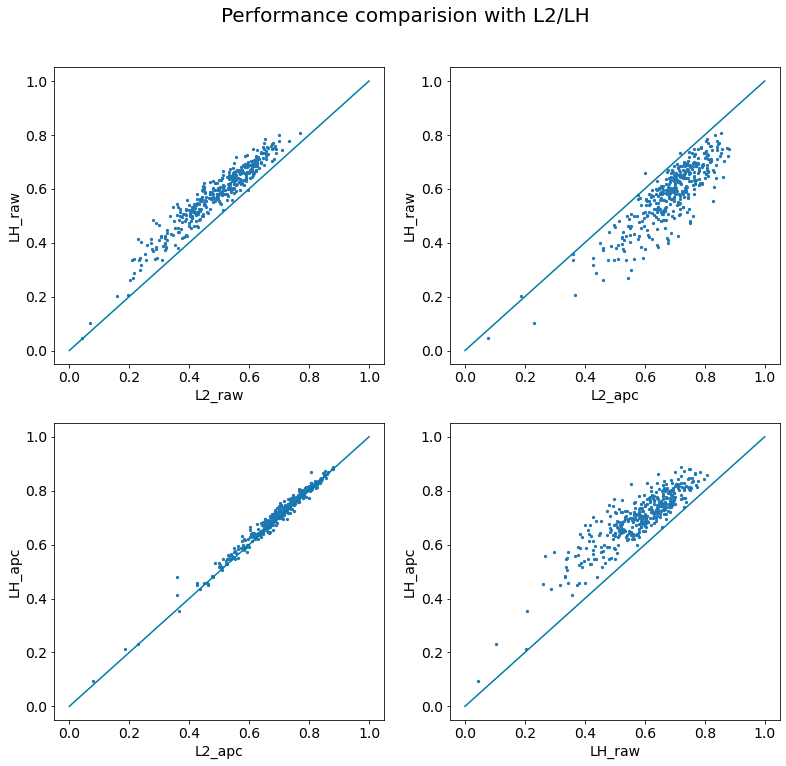

mkdir: cannot create directory ‘LH/encoder_ref_0.02’: File exists


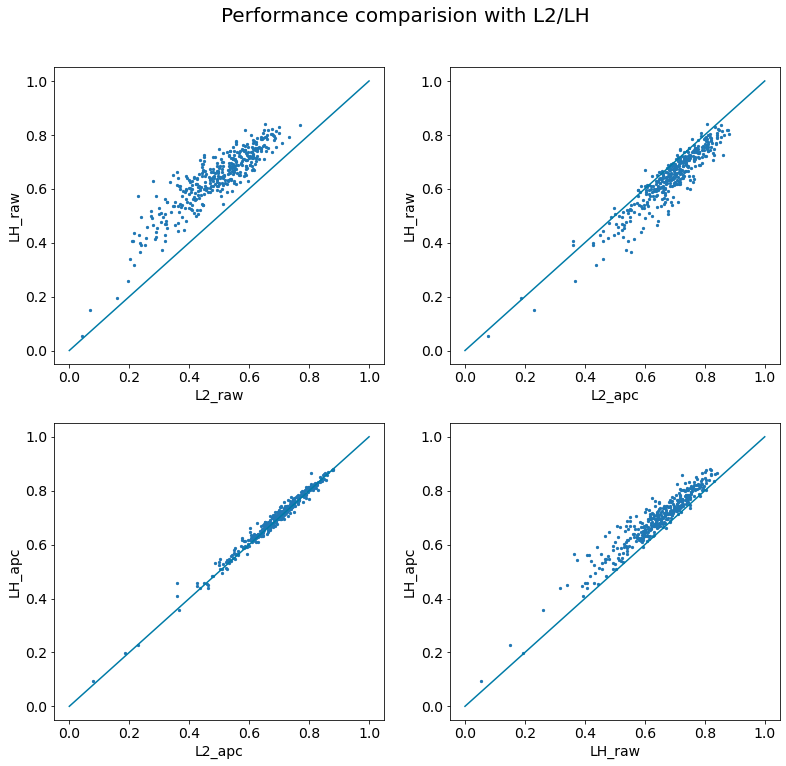

mkdir: cannot create directory ‘LH/encoder_ref_0.05’: File exists


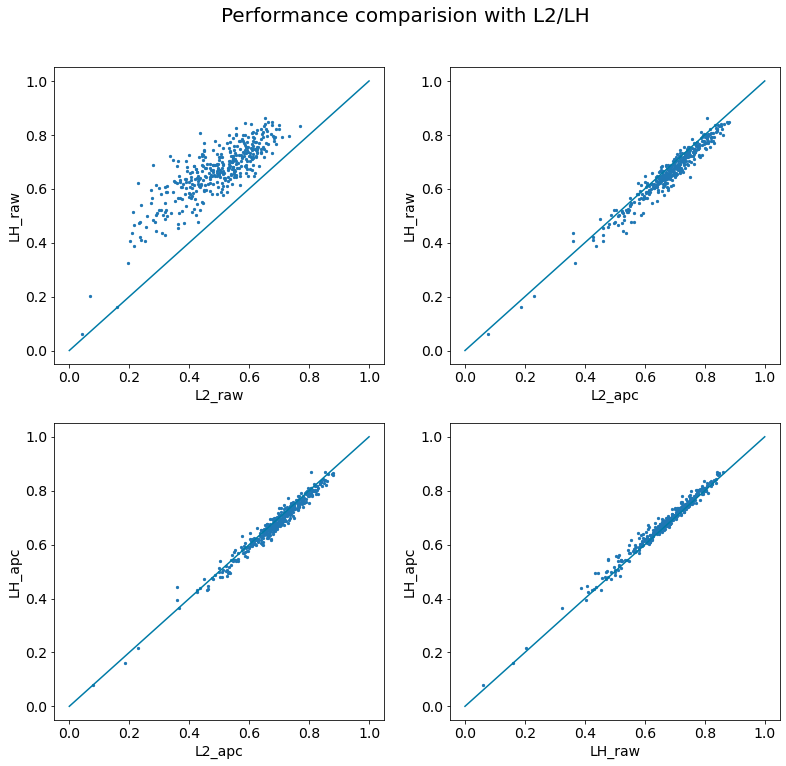

mkdir: cannot create directory ‘LH/encoder_ref_0.1’: File exists


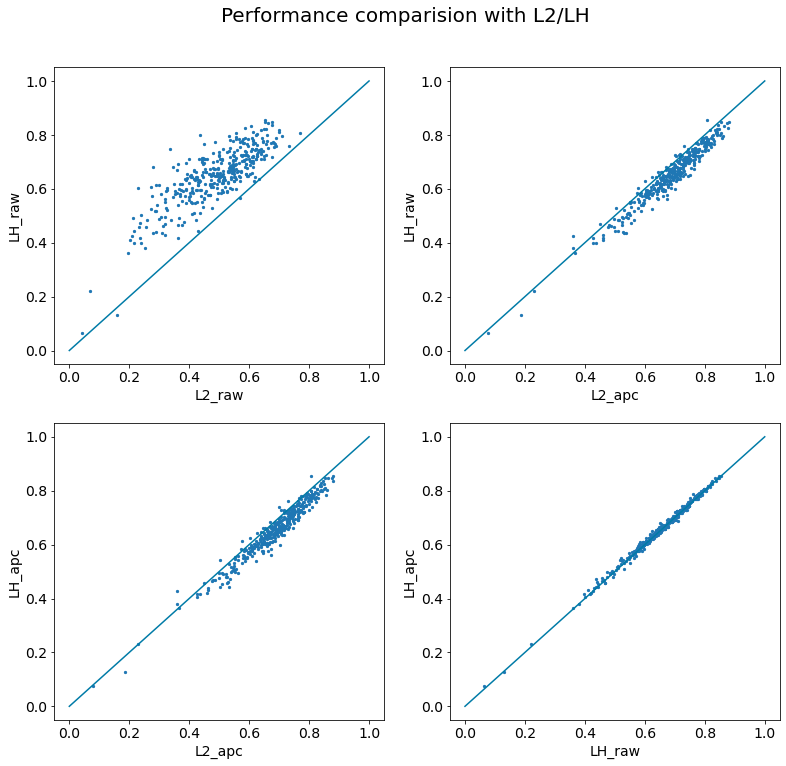

In [ ]:
test_data = data[:]
lambda_list = [0.01,0.02,0.05,0.1,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  !mkdir $state_folder
  for n,a in enumerate(test_data):
    #print(a["x_id"],lambda_LH)
    out_raw = f"{state_folder}/"+a["x_id"]+".raw"
    out_apc = f"{state_folder}/"+a["x_id"]+".apc"
    if os.path.isfile(out_apc) == False:
      raw_apc  = GREMLIN(a["x"],
                          opt_iter = 400,
                          batch_size = 100,
                          reg_mode = reg_mode,
                          power_iter = True,
                          Inv_init = True,
                          lambda_LH = lambda_LH,
                          return_raw = True)

      np.savetxt(out_raw,raw_apc[0])  
      np.savetxt(out_apc,raw_apc[1])
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  plot(np.mean(ACC,axis=(2)),figname=reg_mode)

In [ ]:
performance_LH = list()
#lambda_list = [0.01,0.02,0.05,0.08,0.1,0.2,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  AUC_LH =  np.mean(ACC,axis=(2))
  performance_LH.append([*AUC_LH.mean(0),lambda_LH])
performance_LH = np.array(performance_LH)

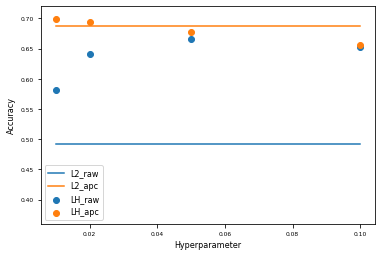

In [ ]:
plt.figure(facecolor="white")
plt.scatter(performance_LH[:,2],performance_LH[:,0],label="LH_raw")
plt.scatter(performance_LH[:,2],performance_LH[:,1],label="LH_apc")
vmin = np.min(lambda_list)
vmax = np.max(lambda_list)
plt.plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
plt.plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
plt.xlabel("Hyperparameter")
plt.ylabel("Accuracy")
plt.ylim(0.36,0.72)
plt.legend()
plt.savefig("Fig2-2.pdf")

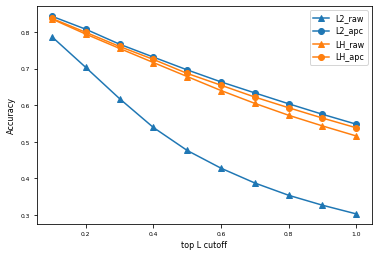

In [ ]:
state_folder = f"{reg_mode}/encoder_ref_0.05" # best LH_apc performance
ACC = get_AUC(state_folder,data=test_data,redo=False)
Cutoff_LH = np.mean(ACC,0)

ACC = get_AUC("ref_w_b",data=test_data,redo=False)
Cutoff_ref = np.mean(ACC,0)

plt.plot(facecolor="white",dpi=300)
plt.plot(np.arange(1,11)*0.1,Cutoff_ref[0],"C0^-",label="L2_raw")
plt.plot(np.arange(1,11)*0.1,Cutoff_ref[1],"C0o-",label="L2_apc")
plt.plot(np.arange(1,11)*0.1,Cutoff_LH[0],"C1^-",label="LH_raw")
plt.plot(np.arange(1,11)*0.1,Cutoff_LH[1],"C1o-",label="LH_apc")
plt.xlabel("top L cutoff")
plt.ylabel("Accuracy")

plt.legend()
plt.savefig("Fig2-3.pdf")

In [ ]:
performance = list()
AUC_ref = get_AUC("AUC_ref",data=test_data,redo=False)[1]
lambda_list = [0.05,]
for lambda_LH in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LH}"
  AUC_LH = get_AUC(state_folder,data=test_data,redo=False)[1]
  performance.append([*AUC_LH.mean(0),lambda_LH])
performance = np.array(performance)

### LB reg

In [ ]:
reg_mode = "LB"
#!rm $reg_mode -rf
!mkdir $reg_mode

mkdir: cannot create directory ‘LB’: File exists


mkdir: cannot create directory ‘LB/encoder_ref_0.001’: File exists


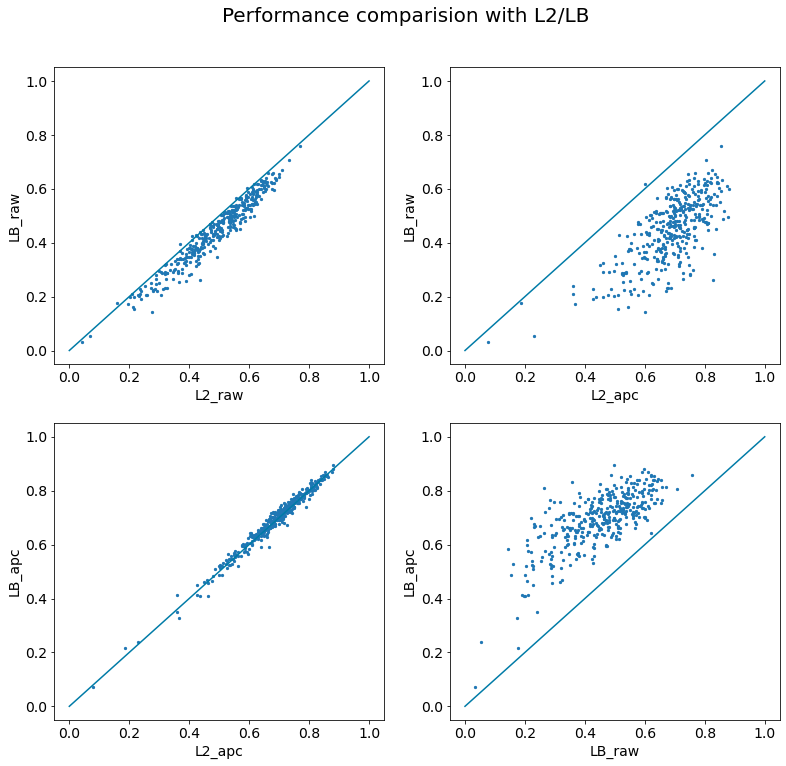

mkdir: cannot create directory ‘LB/encoder_ref_0.002’: File exists


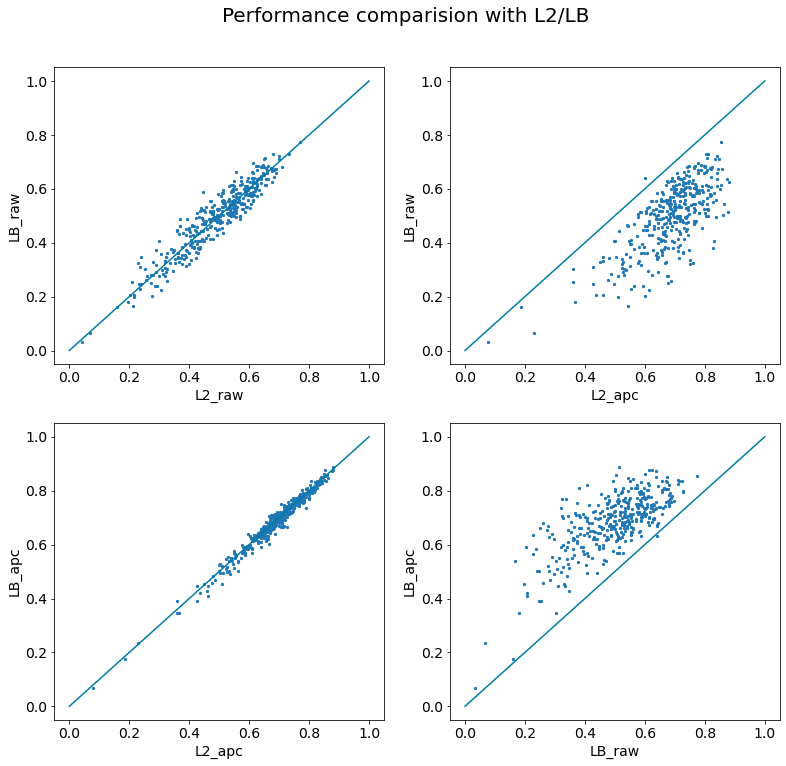

mkdir: cannot create directory ‘LB/encoder_ref_0.005’: File exists


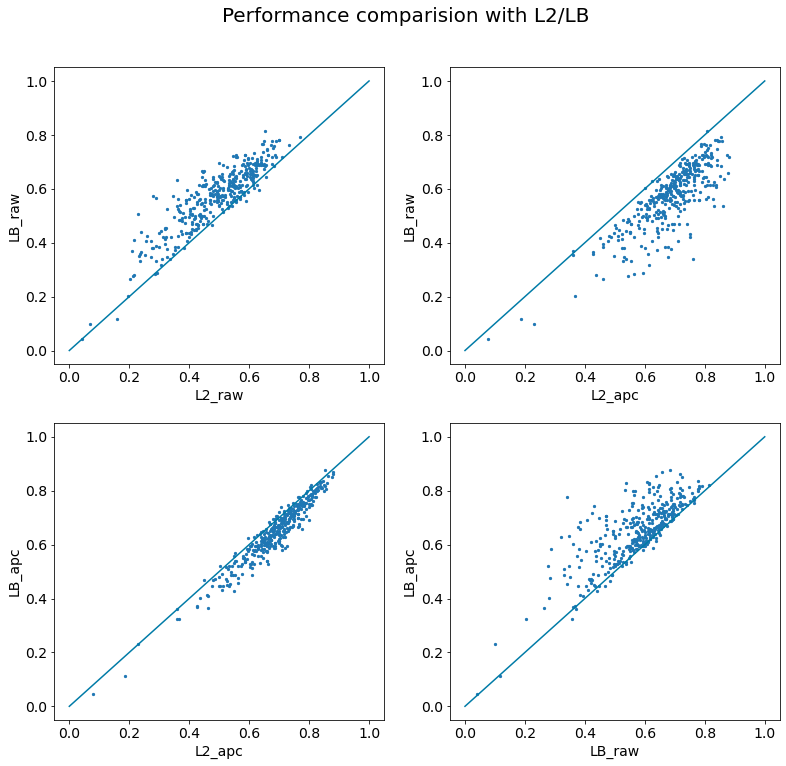

mkdir: cannot create directory ‘LB/encoder_ref_0.01’: File exists


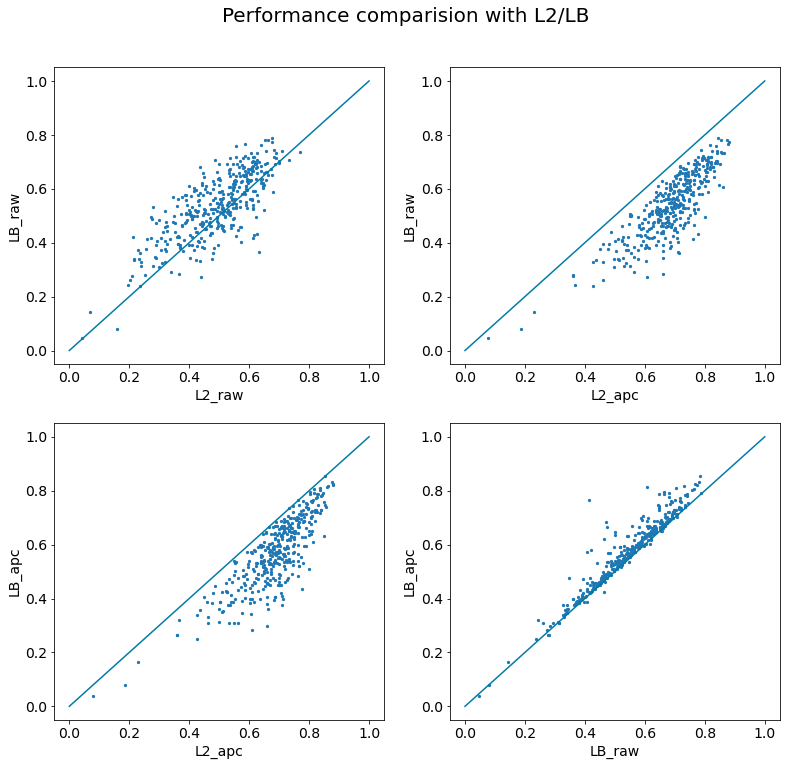

mkdir: cannot create directory ‘LB/encoder_ref_0.02’: File exists


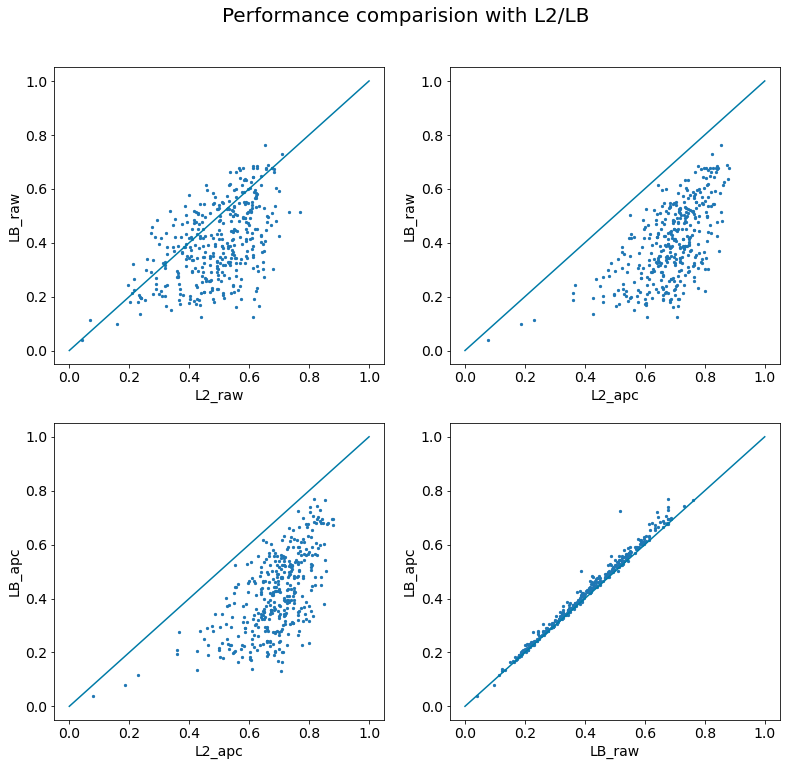

In [ ]:
test_data = data[:]
lambda_list = [0.001,0.002,0.005,0.01,0.02,]
for lambda_LB in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LB}"
  !mkdir $state_folder
  for n,a in enumerate(test_data):
    #print(a["x_id"],lambda_LH)
    out_raw = f"{state_folder}/"+a["x_id"]+".raw"
    out_apc = f"{state_folder}/"+a["x_id"]+".apc"
    if os.path.isfile(out_apc) == False:
      raw_apc  = GREMLIN(a["x"],
                          opt_iter = 400,
                          batch_size = 100,
                          reg_mode = reg_mode,
                          power_iter = True,
                          Inv_init = False,
                          lambda_LB = lambda_LB,
                          return_raw = True)

      np.savetxt(out_raw,raw_apc[0])  
      np.savetxt(out_apc,raw_apc[1])
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  plot(np.mean(ACC,axis=(2)),figname=reg_mode)

In [ ]:
performance_LB = list()
#lambda_list = [0.01,0.02,0.05,0.08,0.1,0.2,]
for lambda_LB in lambda_list:
  state_folder = f"{reg_mode}/encoder_ref_{lambda_LB}"
  ACC = get_AUC(state_folder,data=test_data,redo=False)
  AUC_LB =  np.mean(ACC,axis=(2))
  performance_LB.append([*AUC_LB.mean(0),lambda_LB])
performance_LB = np.array(performance_LB)

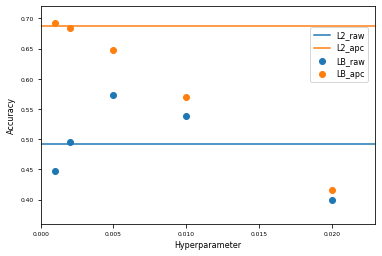

In [ ]:
plt.figure(facecolor="white")
plt.scatter(performance_LB[:,2],performance_LB[:,0],label="LB_raw")
plt.scatter(performance_LB[:,2],performance_LB[:,1],label="LB_apc")
vmin = np.min(0)
vmax = np.max(0.023)
plt.plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
plt.plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
plt.xlabel("Hyperparameter")
plt.ylabel("Accuracy")
plt.ylim(0.36,0.72)
plt.xlim(0,0.023)
plt.legend(bbox_to_anchor=(0.04, 0.82, 0.95, .102))
plt.savefig("Fig2-2.pdf")

### Summary

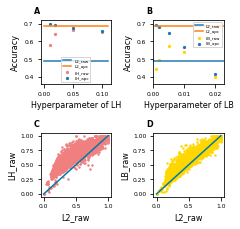

In [ ]:
fig = plt.figure(figsize=(3.25,3.25),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=8, weight='bold')
  
vmin = np.min(0);vmax = np.max(0.023)


axes[0].scatter(performance_LH[:,2],performance_LH[:,0],s=5,label="LH_raw",c="lightcoral")
axes[0].scatter(performance_LH[:,2],performance_LH[:,1],s=5,label="LH_apc")
axes[0].plot([0,0.11],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
axes[0].plot([0,0.11],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
axes[0].set_xlabel("Hyperparameter of LH")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0.36,0.72)
axes[0].legend(prop={'size': 4})


axes[1].scatter(performance_LB[:,2],performance_LB[:,0],s=5,label="LB_raw",c="gold")
axes[1].scatter(performance_LB[:,2],performance_LB[:,1],s=5,label="LB_apc")
axes[1].plot([vmin,vmax],[AUC_ref.mean(0)[0],AUC_ref.mean(0)[0]],label="L2_raw")
axes[1].plot([vmin,vmax],[AUC_ref.mean(0)[1],AUC_ref.mean(0)[1]],label="L2_apc")
axes[1].set_xlabel("Hyperparameter of LB")
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0.36,0.72)
axes[1].set_xlim(0,0.023)
axes[1].legend(prop={'size': 4})


LH_folder = f"LH/encoder_ref_0.05" # best LH_apc performance
ACC_LH = get_AUC(LH_folder,data=test_data,redo=False)


ACC_ref = get_AUC("ref_w_b",data=test_data,redo=False)

idx = ACC_LH.shape[0]
axes[2].plot( [0,1],[0,1], color="#007BA7")
axes[2].scatter(ACC_ref[:idx,0],ACC_LH[:,0],s=2,c="lightcoral")
axes[2].set_xlabel("L2_raw")
axes[2].set_ylabel(f"LH_raw")
#axes[2].tick_params(axis='both', which='major', labelsize=14)

LB_folder = f"LB/encoder_ref_0.005" # best LH_apc performance
ACC_LB = get_AUC(LB_folder,data=test_data,redo=False)

axes[3].plot( [0,1],[0,1], color="#007BA7")
axes[3].scatter(ACC_ref[:idx,0],ACC_LB[:,0],s=2,c="gold")
axes[3].set_xlabel("L2_raw")
axes[3].set_ylabel(f"LB_raw")
#axes[3].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.savefig("/content/unsupervised_learning.pdf")

## supervised learning


In [ ]:
import joblib
from matplotlib import cm
from matplotlib import colors as c_rgb

In [ ]:
!wget -q -nc http://www.structpred.club/~cybertruck/for_colab/precision/precision.pkl

In [ ]:
precision = joblib.load('precision.pkl')
L2_apc = precision['L2_apc']
LB_apc = precision['LB_apc']
LH_apc = precision['LH_apc']
L2_raw = precision['L2_raw']
LB_raw = precision['LB_raw']
LH_raw = precision['LH_raw']
L2_NN = precision['L2_NN']
LB_NN = precision['LB_NN']
LH_NN = precision['LH_NN']

In [ ]:
def set_box_color(bp, color):
    # plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

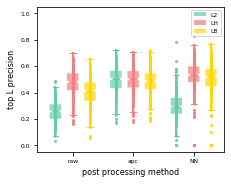

In [ ]:

fig = plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 

fig.canvas.draw()


top_index = 3

results = [[L2_raw[:, 0, top_index],L2_apc[:, 0, top_index], L2_NN[:, 0, top_index]],
           [LH_raw[:, 0, top_index], LH_apc[:, 0, top_index],  LH_NN[:, 0, top_index]],
           [LB_raw[:, 0, top_index],LB_apc[:, 0, top_index], LB_NN[:, 0, top_index]]
           ]

labels = ['L2', 'LH', "LB"]
tick_label = ['raw', 'apc', 'NN']

start_pos = np.array([-2.4,-0, 2.4, ])
tick_pos = np.array([0, 8.4, 16.8])

viridis = cm.get_cmap('GnBu', 256)
colors = viridis(np.linspace(0.4, 0.95, len(start_pos)))
colors = [c_rgb.to_rgb("mediumaquamarine"),c_rgb.to_rgb("lightcoral"),c_rgb.to_rgb("gold")]
opacity = 0.7
opacity_dot = 0.8

bpl_list = []
for ith, result in enumerate(results):
    positions = start_pos[ith] + tick_pos
    bpl = plt.boxplot(result,
                      positions=positions,
                      flierprops=dict(marker='o',
                              markerfacecolor=list(
                                  colors[ith][:3]) + [opacity_dot],
                              markersize=3, linestyle='none', markeredgecolor='white',
                              markeredgewidth=0),
                      notch=True,
                      patch_artist=True,
                      widths=1.6,
                      boxprops=dict(linestyle='-', linewidth=0.6,
                              facecolor=list(
                                  colors[ith][:3]) + [opacity],
                              edgecolor=list(colors[ith][:3]) + [0]),
                      whiskerprops=dict(linestyle='-', linewidth=2.0, color='black'))
    set_box_color(bpl,colors[ith])
    bpl_list.append(bpl["boxes"][0])

    # plot data points
    for jth, jresult in enumerate(result):
      plt.scatter([positions[jth]]*len(jresult), jresult, color=colors[ith],
              marker='o', s=2, alpha=opacity_dot)
      
plt.legend(bpl_list, ['L2', 'LH', 'LB',],
      loc='upper right',prop={'size':6})

plt.xticks(tick_pos, tick_label)
plt.ylim(-0.05, 1.05)
plt.xlim(-5, 21)
plt.ylabel("top L precision")
plt.xlabel("post processing method")
plt.tight_layout()
plt.savefig("/content/NN.pdf")
plt.show()

# application

In [ ]:
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/asr.tar

In [ ]:
!tar -zxf asr.tar


gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now


In [ ]:
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ADKMLBay_3.fasta
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/Adk_201602.fas
!wget -q -nc https://files.rcsb.org/download/1P3J.pdb
!wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ADK_paper.fasta

## GAGB 
ref [Co-Evolutionary Fitness Landscapes for Sequence Design!](https://onlinelibrary.wiley.com/doi/abs/10.1002/anie.201713220)

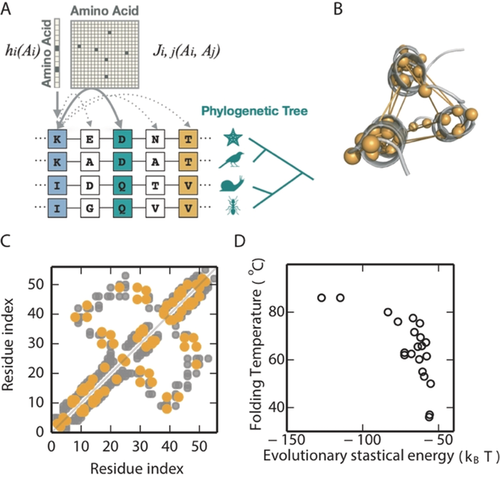

In [ ]:
!wget -q -nc http://structpred.club/~cybertruck/LH/applications/gagb.tar

In [ ]:
!tar -xvf gagb.tar

GAGB/
GAGB/GAGB_Tm_experiment.dat
GAGB/ga_msa.fas
GAGB/gb_msa.fas


In [ ]:
#load msas
names,seqs_ga = parse_fasta("GAGB/ga_msa.fas")
seqs_gb = parse_aln("GAGB/gb_msa.fas")
msa_ga,_ = mk_msa(seqs_ga)
msa_gb,_ = mk_msa(seqs_gb)
print(msa_ga.shape,msa_gb.shape)

(940, 56) (702, 56)


In [ ]:
# get folding temperature and test sequence
names,seqs = parse_fasta("GAGB/GAGB_Tm_experiment.dat")

tag = []
for i in names:
  tag.append([float(i.split()[1]),i[0]])
tag = np.array(tag)
tm = np.array(tag[:,0]).astype(float)
_,test_msa = mk_msa(seqs)

idx = np.where(tm>20) #unfold protein
tm = tm[idx]
test_msa = test_msa[idx]
tag = tag[idx]

p_type = np.array(tag[:,1])

A_type = np.where(p_type=="A")
B_type = np.where(p_type=="B")



In [ ]:
# train the model
GA_V_L2,GA_W_L2 = GREMLIN(msa_ga,opt_iter=500,reg_mode="L2",param_flag=True)
GB_V_L2,GB_W_L2 = GREMLIN(msa_gb,opt_iter=500,reg_mode="L2",param_flag=True)

GA_V_LH,GA_W_LH  = GREMLIN(msa_ga,opt_iter=500,reg_mode="LH",param_flag=True)
GB_V_LH,GB_W_LH = GREMLIN(msa_gb,opt_iter=500,reg_mode="LH",param_flag=True)

In [ ]:
return_H = True
test_GA_Loss_LH =  get_Hamiltonian_loss(test_msa,GA_W_LH,GA_V_LH,return_H = return_H)
test_GA_Loss_L2 =  get_Hamiltonian_loss(test_msa,GA_W_L2,GA_V_L2,return_H = return_H)

test_GB_Loss_LH =  get_Hamiltonian_loss(test_msa,GB_W_LH,GB_V_LH,return_H = return_H)
test_GB_Loss_L2 =  get_Hamiltonian_loss(test_msa,GB_W_L2,GB_V_L2,return_H = return_H)

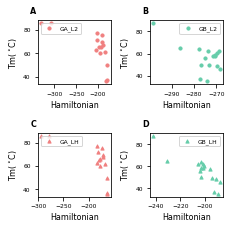

In [ ]:
fig = plt.figure(figsize=(3.25,3.25),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=6) 
plt.rc('ytick', labelsize=6) 

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=8, weight='bold')

axes[0].scatter(test_GA_Loss_L2[A_type],tm[A_type],label = "GA_L2",marker = "o",s=10,c='lightcoral')
axes[0].set_xlabel("Hamiltonian")
axes[0].set_ylabel("Tm($^\circ$C)")
axes[0].legend(prop={"size":6})

axes[1].scatter(test_GB_Loss_L2[B_type],tm[B_type],label = "GB_L2",marker = "o",s=10,c='mediumaquamarine')
axes[1].set_xlabel("Hamiltonian")
axes[1].set_ylabel("Tm($^\circ$C)")
axes[1].legend(prop={"size":6})

axes[2].scatter(test_GA_Loss_LH[A_type],tm[A_type],label = "GA_LH",marker = "^",s=10,c='lightcoral')
axes[2].set_xlabel("Hamiltonian")
axes[2].set_ylabel("Tm($^\circ$C)")
axes[2].legend(prop={"size":6})

axes[3].scatter(test_GB_Loss_LH[B_type],tm[B_type],label = "GB_LH",marker = "^",s=10,c='mediumaquamarine')
axes[3].legend(prop={"size":6})
axes[3].set_xlabel("Hamiltonian")
axes[3].set_ylabel("Tm($^\circ$C)")

plt.tight_layout()
plt.savefig("/content/GAGB.pdf")


In [ ]:
print("GA_L2",np.round(scipy.stats.spearmanr(test_GA_Loss_L2[A_type],tm[A_type])[0],2),"\n"
"GA_LH",np.round(scipy.stats.spearmanr(test_GA_Loss_LH[A_type],tm[A_type])[0],2),"\n"
"GB_L2",np.round(scipy.stats.spearmanr(test_GB_Loss_L2[B_type],tm[B_type])[0],2),"\n"
"GB_LH",np.round(scipy.stats.spearmanr(test_GB_Loss_LH[B_type],tm[B_type])[0],2)
)

GA_L2 -0.73 
GA_LH -0.76 
GB_L2 -0.31 
GB_LH -0.81


## chorismate mutase enyzme
 [An evolution-based model for designing chorismate mutase enzymes](https://science.sciencemag.org/content/369/6502/440/)

#### install bmDCA

In [ ]:
# lib installation
! sudo apt-get update
! sudo apt-get install git gcc g++ automake autoconf pkg-config \
  libarmadillo-dev libopenblas-dev libarpack++2-dev

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [717 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://securit

In [ ]:
cd /content

/content


In [ ]:
%%bash
# download and install bmDCA
git clone https://github.com/ranganathanlab/bmDCA.git
cd bmDCA
./autogen.sh --prefix=/usr/local && \
make -j4 && \
make install
cd ..

checking build system type... x86_64-pc-linux-gnu
checking host system type... x86_64-pc-linux-gnu
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /bin/mkdir -p
checking for gawk... no
checking for mawk... mawk
checking whether make sets $(MAKE)... yes
checking whether make supports nested variables... yes
checking whether to enable maintainer-specific portions of Makefiles... yes
checking whether make supports nested variables... (cached) yes
checking for g++... g++
checking whether the C++ compiler works... yes
checking for C++ compiler default output file name... a.out
checking for suffix of executables... 
checking whether we are cross compiling... no
checking for suffix of object files... o
checking whether we are using the GNU C++ compiler... yes
checking whether g++ accepts -g... yes
checking for style of include used by make... GNU
checking dependency style of g++... gcc3
check

Cloning into 'bmDCA'...
configure.ac:8: installing './config.guess'
configure.ac:8: installing './config.sub'
configure.ac:35: installing './install-sh'
configure.ac:35: installing './missing'
src/Makefile.am: installing './depcomp'
+ ./configure --prefix=/usr/local
run.cpp: In constructor ‘Sim::Sim(MSAStats, std::__cxx11::string, std::__cxx11::string, bool)’:
run.cpp:383:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~
bmdca_sample.cpp: In function ‘int main(int, char**)’:
bmdca_sample.cpp:124:10: warning: ignoring return value of ‘int chdir(const char*)’, declared with attribute warn_unused_result [-Wunused-result]
     chdir(dest_dir.c_str());
     ~~~~~^~~~~~~~~~~~~~~~~~


In [ ]:
!mkdir sampling_result

#### download dataset from paper

In [ ]:
!wget -q -nc http://structpred.club/~cybertruck/LH/applications/bmdca.tar
!tar -xvf bmdca.tar

bmdca/
bmdca/aba3304_Table_S3.csv
bmdca/aba3304_Table_S2.csv
bmdca/science_head.fas
bmdca/aba3304_Table_S1.csv


#### parse the data

In [ ]:
sample_dict = {}

with open("bmdca/aba3304_Table_S1.csv",'r') as f:
  seqs = []
  Es = []
  re = []
  for line in f.readlines()[4:]:
    line = line.strip().split(",")
    seq = str(line[-5])
    energy = float(line[-2])
    normre = float(line[-1])
    seqs.append(seq)
    Es.append(energy)
    re.append(normre)
sample_dict["nature"] = [seqs.copy(),Es.copy(),re.copy()]


with open("bmdca/aba3304_Table_S2.csv",'r') as f:
### three different sampling temperature 
  flag = 0
  for line in f.readlines():
    line = line.strip()  
    if "T=" in line:
      t = str(line.split("T=")[1].split(",")[0])
    if "Sequence" in line:
      flag = 1
      seqs = []
      Es = []
      re = []
      continue
    if flag == 1:
      if ",,,,,,," in line:
        flag = 0
        sample_dict[t] = [seqs.copy(),Es.copy(),re.copy()]
      else:
        line = line.split(",")
        seq = str(line[3])
        energy = float(line[6])
        normre = float(line[7])
        seqs.append(seq)
        Es.append(energy)
        re.append(normre)
  sample_dict[t] = [seqs.copy(),Es.copy(),re.copy()]

flag = 0
with open("bmdca/aba3304_Table_S3.csv",'r') as f:
  seqs = []
  Es = []
  re = []
  for line in f.readlines()[4:]:
    line = line.strip().split(",")
    seq = str(line[1])
    energy = float(line[4])
    normre = float(line[5])
    seqs.append(seq)
    Es.append(energy)
    re.append(normre)

#idx = 0,1,2
sample_dict["pssm"] = [seqs.copy(),Es.copy(),re.copy()]


### run LH model

In [ ]:
# a label based function 
def get_loss(t,W,V):
  seqs = sample_dict[t][0]
  _,msa = mk_msa(seqs)
  return get_Hamiltonian_loss(msa,W,V)

the contact map generated by LH


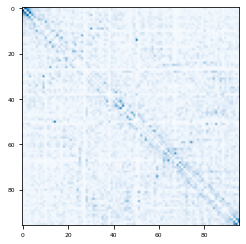

In [ ]:
t = "nature"
seqs = sample_dict[t][0]
Es = sample_dict[t][1]
re = sample_dict[t][2]
msa_ori_nature,msa_nature = mk_msa(seqs)

V_LH,W_LH = GREMLIN(msa_ori_nature,reg_mode="LH",lambda_LH=0.1,param_flag=True)

Loss_mean = np.mean(get_loss("nature",W_LH,V_LH))
for t in ["nature","0.33","0.66","1","pssm"]:
  Loss_LH = get_loss(t,W_LH,V_LH)
  Loss_LH = Loss_LH - Loss_mean
  #idx = 3
  sample_dict[t].append(Loss_LH)

raw, apc = get_mtx(W_LH)
print("the contact map generated by LH")
plt.imshow(raw,cmap="Blues")
plt.grid(False)

#### classify sequences by functions

Both of these two failed to separate because of natural sequence pollution!

463 666
309 184
193 317
31 584


/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


0 325


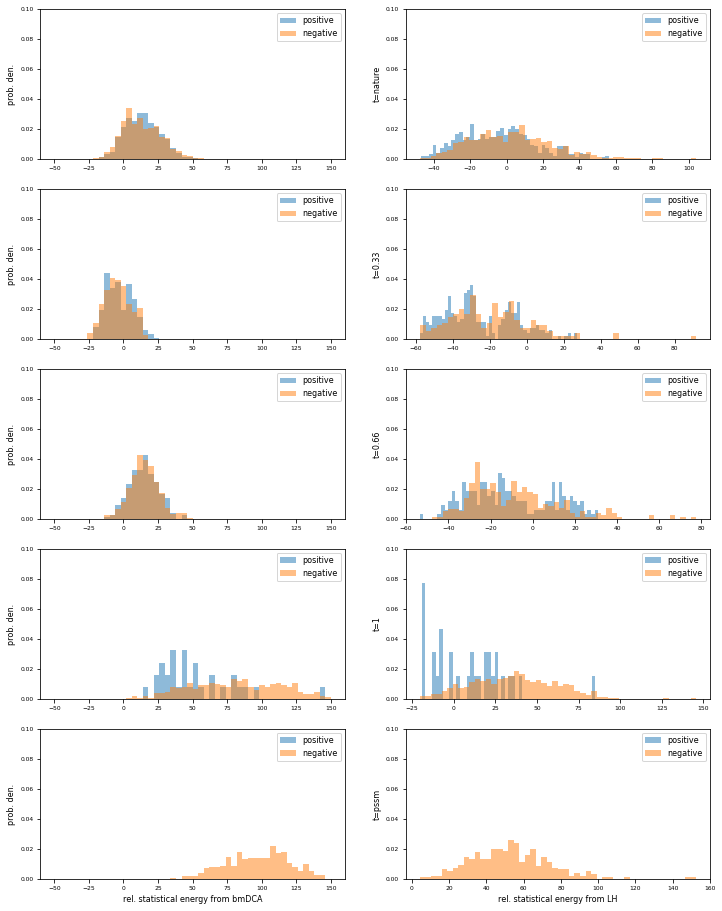

In [ ]:
plt.figure(figsize=(12,16),facecolor="white")
cutoff=0.25
for i,t in enumerate(["nature","0.33","0.66","1","pssm"]):

  re = sample_dict[t][2]

  Positive_idx = np.where(np.array(re)>cutoff)
  Negative_idx = np.where(np.array(re)<=cutoff)

  plt.subplot(5,2,2*i+1)
  Es = np.array(sample_dict[t][1])
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,density=True,range=(-50,150),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,density=True,range=(-50,150),label="negative")
  plt.ylim(0,0.1)
  plt.ylabel("prob. den.")
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from bmDCA")

  plt.subplot(5,2,2*i+2)
  plt.ylabel(f"t={t}")
  Es = sample_dict[t][3]
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,density=True,label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,density=True,label="negative")
  print(len(Es[Positive_idx]),len(Es[Negative_idx]))
  #plt.ylabel("prob. den.")
  plt.ylim(0,0.1)
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from LH")

plt.legend()
plt.show()

In [ ]:
# reverse tranlate numbers into AAs for furthur use
t = "nature"
msa_ori,msa = mk_msa(sample_dict[t][0])
re = sample_dict[t][2]
Positive_idx = np.where(np.array(re)>cutoff)
msa_ori_filter = msa_ori[Positive_idx]
seqs = []
for i in range(msa_ori_filter.shape[0]):
  seq = []
  for j in msa_ori_filter[i]:
    aa = alphabet[j]
    seq.append(aa)
  seq = "".join(seq)
  seqs.append(seq)

#changing aln file to fas file
with open("CM_0.25.fas", 'w') as out:
  for i in range(len(seqs)):
    out.write(f">seqs_{i}\n{seqs[i]}\n")

### Rerun bmDCA with filtered MSA

In [ ]:
### MSA filter with all norm r.e. >0.25 
##suspect there exists unfunctional sequences in the same MSA.
sample_filter_dict = sample_dict.copy()
seqs = sample_filter_dict["nature"][0]

#get the Es >0.25 as input data
pos_idx = np.where(np.array(sample_filter_dict["nature"][2]) >0.25)
seq_filter = np.array(seqs)[pos_idx]

#changing aln file to fas file
with open("msa.fas", 'w') as out:
  for i in range(len(seq_filter)):
    out.write(f">seqs_{i}\n{seq_filter[i]}\n")

In [ ]:
# this step took too long time (over 100h in 12 core CPUs) to run, so I uploaded the result at somewhere
# if you want to repeat the bmDCA, you can uncomment the commands and try running this locally.
'''%%bash
bmdca -i msa.fas -r -d bmdca_result -c bmDCA/example/bmdca.conf 
arma2ascii -p bmdca_result/parameters_h_final.bin -P bmdca_result/parameters_J_final.bin'''

!wget -q -nc  http://structpred.club/~cybertruck/LH/applications/parameters_1900.txt -O parameter_L2BM.txt

In [ ]:
def txt2mtx(filename):
  W = np.zeros_like(W_LH)
  V = np.zeros_like(V_LH)
  with open(filename, 'r') as filehandle:
    for line in filehandle:
      line = line.strip()
      line = line.split(" ")
      if line[0] == "J":
        i = int(line[1])
        j = int(line[2])
        a = int(line[3])
        b = int(line[4])
        n = float(line[5])
        W[i,a,j,b] = n
        W[j,a,i,b] = n
      if line[0] == "h":
        i = int(line[1])
        j = int(line[2])
        n = float(line[3])
        V[i,j] = n
  return V,W

V_L2BM,W_L2BM = txt2mtx("parameter_L2BM.txt")

### calculating W matrix

In [ ]:
### MSA filter with all norm r.e. >0.25
##suspect there exists unfunctional sequences in the same MSA.

seqs = sample_dict["nature"][0]
pos_idx = np.where(np.array(re) >0.25)
seq_filter = np.array(seqs)[pos_idx]

#changing aln file to fas file
with open("msa.fas", 'w') as out:
  for i in range(len(seq_filter)):
    out.write(f">seqs_{i}\n{seq_filter[i]}\n")

# calculate L2 and LH
V_LH, W_LH = GREMLIN(msa_ori_nature[pos_idx],reg_mode="LH",param_flag=True)
V_L2, W_L2 = GREMLIN(msa_ori_nature[pos_idx],reg_mode="L2",param_flag=True)

#V_LH, W_LH = GREMLIN(msa_ori_nature,reg_mode="LH",param_flag=True)
#V_L2, W_L2 = GREMLIN(msa_ori_nature,reg_mode="L2",param_flag=True)

LH_mean = np.mean(get_loss("nature",W_LH,V_LH))
L2_mean = np.mean(get_loss("nature",W_L2,V_L2))
L2BM_mean = np.mean(get_loss("nature",W_L2BM,V_L2BM))

for t in ["nature","0.33","0.66","1","pssm"]:
  #idx = 4
  Loss_LH = get_loss(t,W_LH,V_LH)
  Loss_LH = Loss_LH - LH_mean
  sample_dict[t].append(Loss_LH)
  #idx = 5
  Loss_L2 = get_loss(t,W_L2,V_L2)
  Loss_L2 = Loss_L2 - L2_mean
  sample_dict[t].append(Loss_L2)
  #idx = 6
  Loss_L2BM = get_loss(t,W_L2BM,V_L2BM)
  Loss_L2BM = Loss_L2BM - L2BM_mean
  sample_dict[t].append(Loss_L2BM)

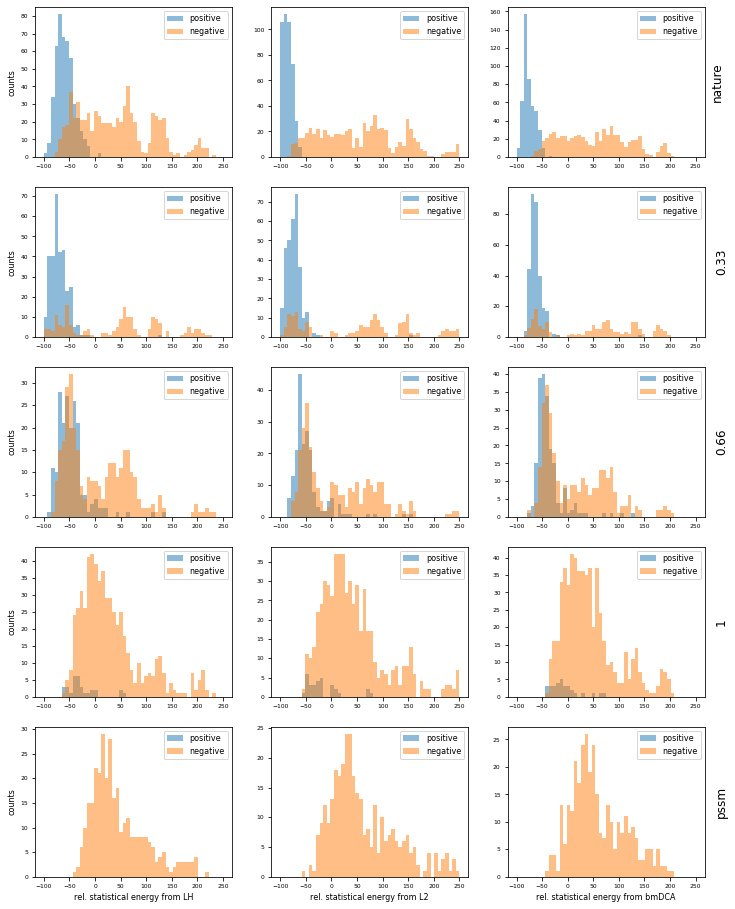

In [ ]:
plt.figure(figsize=(12,16),facecolor="white")
cutoff=0.25
for i,t in enumerate(["nature","0.33","0.66","1","pssm"]):

  re = sample_dict[t][2]

  Positive_idx = np.where(np.array(re)>cutoff)
  Negative_idx = np.where(np.array(re)<=cutoff)


  plt.subplot(5,3,3*i+1)
  Es = sample_dict[t][4] # MSA filter with LH
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  plt.ylabel("counts")
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from LH")
  

  plt.subplot(5,3,3*i+2)
  Es = sample_dict[t][5] # MSA filter with L2
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from L2")


  plt.subplot(5,3,3*i+3)
  Es = sample_dict[t][6] # MSA filter with bmDCA
  plt.hist(Es[Positive_idx], bins=50,alpha=0.5,range=(-100,250),label="positive")
  plt.hist(Es[Negative_idx], bins=50,alpha=0.5,range=(-100,250),label="negative")
  #plt.ylabel("prob. den.")
  #plt.ylim(0,0.1)
  plt.legend()
  plt.ylabel(t, labelpad=-235,fontsize=12)
  if i ==4: #the nineth plot
    plt.xlabel("rel. statistical energy from bmDCA")

plt.legend()
plt.savefig("/content/filtered_msa_bmdca.pdf")

#### resample

In [ ]:
# utils
def save_parameter(filename,W,V):
  ''' this function is to translate potts model paramter 
  to a bmdca_sample input format.
  W: two body term
  V: one body term
  '''
  L,A = V.shape
  with open(filename, 'w') as out:
    for i in range(L):
      for j in range(L):
        for a in range(A):
          for b in range(A):
            if i<j:
              out.write(f"J {i} {j} {a} {b} {W[i,a,j,b]}\n")
    for i in range(L):
      for a in range(A): 
        out.write(f"H {i} {a} {V[i,a]}\n")

save_parameter("parameter_L2.txt",W_L2,V_L2)
save_parameter("parameter_LH.txt",W_LH,V_LH)

### sequence sampling

In [ ]:
!./bmDCA/src/bmdca_sample -h

bmdca_sample usage:
(e.g. bmdca_sample -p <params h> -P <params|params J> -c <config file> \
                   -n <# samples per thread> -r <# threads> \
                   -d <directory> -o <output flle>)
  -p: parameters (txt) _or_ fields h (bin)
  -P: couplings J (bin), required if fields h given
  -d: destination directory
  -o: output file name
  -r: # independent sampling runs
  -n: # samples obtained per sampling run
  -c: config file
  -h: print usage (i.e. this message)


In [ ]:
# 10 independent runs * 1,000 sequneces = 10,000 sequences
!./bmDCA/src/bmdca_sample -p parameter_L2.txt -d sampling_result/ -o L2.txt -n 10000
!./bmDCA/src/bmdca_sample -p parameter_LH.txt -d sampling_result/ -o LH.txt -n 10000
!./bmDCA/src/bmdca_sample -p parameter_L2BM.txt -d sampling_result/ -o L2BM.txt -n 10000

initializing sampler... 1.92653 sec

sampling model with mcmc... 44.5863 sec
updating mcmc stats with samples... 2.00998 sec
computing sequence energies and correlations... 5.75625 sec
writing final sequences... done
initializing sampler... 1.9247 sec

sampling model with mcmc... 44.8341 sec
updating mcmc stats with samples... 2.00671 sec
computing sequence energies and correlations... 5.91259 sec
writing final sequences... done
initializing sampler... 1.95452 sec

sampling model with mcmc... 44.5001 sec
updating mcmc stats with samples... 2.02442 sec
computing sequence energies and correlations... 5.97953 sec
writing final sequences... done


### calculate pair_pssm

In [ ]:
#get one hotted msa
names, seqs_L2 = parse_fasta("/content/sampling_result/L2.txt")
_, msa_gen_L2 = mk_msa(seqs_L2)

names, seqs_LH = parse_fasta("/content/sampling_result/LH.txt")
_, msa_gen_LH = mk_msa(seqs_LH)

names, seqs_L2BM = parse_fasta("/content/sampling_result/L2BM.txt")
_, msa_gen_L2BM = mk_msa(seqs_L2BM)

#_,msa_nature = mk_msa(seq_filter)

### pairwise_frequency

In [ ]:
# the input pair_pssm information
train_pssm = get_pssm(msa_nature)
train_pair_pssm = get_pair_pssm(msa_nature)

In [ ]:
L2_pssm = get_pssm(msa_gen_L2)
LH_pssm = get_pssm(msa_gen_LH)
L2BM_pssm = get_pssm(msa_gen_L2BM)

L2_pair_pssm = get_pair_pssm(msa_gen_L2)
LH_pair_pssm = get_pair_pssm(msa_gen_LH)
L2BM_pair_pssm = get_pair_pssm(msa_gen_L2BM)

Null_pair_pssm = get_pair_pssm(msa_null)

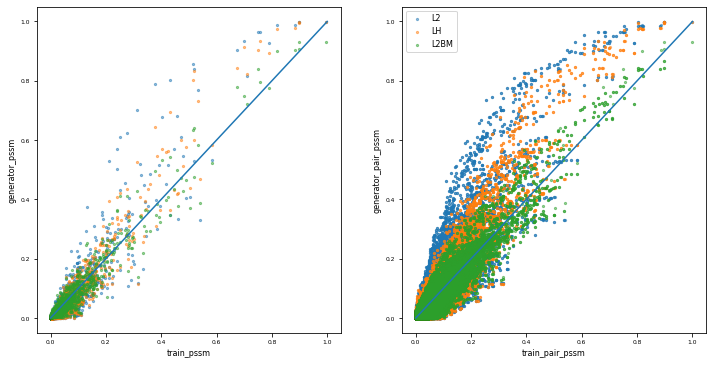

In [ ]:
plt.figure(figsize=(12,6),facecolor="white")

plt.title("CM")
plt.subplot(1,2,1)
plt.scatter(train_pssm,L2_pssm,s=5,alpha=0.5,label="L2")
plt.scatter(train_pssm,LH_pssm,s=5,alpha=0.5,label="LH")
plt.scatter(train_pssm,L2BM_pssm,s=5,alpha=0.5,label="L2BM")
plt.plot([0,1],[0,1])
plt.xlabel("train_pssm")
plt.ylabel("generator_pssm")

plt.subplot(1,2,2)
plt.scatter(train_pair_pssm,L2_pair_pssm,s=5,alpha=0.5,label="L2")
plt.scatter(train_pair_pssm,LH_pair_pssm,s=5,alpha=0.5,label="LH")
plt.scatter(train_pair_pssm,L2BM_pair_pssm,s=5,alpha=0.5,label="L2BM")

plt.plot([0,1],[0,1])
plt.xlabel("train_pair_pssm")
plt.ylabel("generator_pair_pssm")

plt.legend()
plt.savefig("/content/pair_pssm.png")

#### coevolutionary info check using MI

In [ ]:
def get_MI(pssm,pair_pssm):
  H = np.sum(-pssm * np.log(pssm+1e-8),-1)
  HH = np.sum(-pair_pssm * np.log(pair_pssm+1e-8),(1,3))
  MI =  H[None,:] + H[:,None] - HH 
  np.fill_diagonal(MI,0)
  ap = np.sum(MI,0)
  apc  = MI - ap[None,:]*ap[:,None]/np.sum(ap)
  
  return MI,apc

In [ ]:
MI_train,MI_train_APC = get_MI(train_pssm,train_pair_pssm)
MI_L2,MI_L2_APC = get_MI(L2_pssm,L2_pair_pssm)
MI_LH,MI_LH_APC = get_MI(LH_pssm,LH_pair_pssm)
MI_L2BM,MI_L2BM_APC = get_MI(L2BM_pssm,L2BM_pair_pssm)
#MI_pssm,MI_pssm_APC = get_MI(train_pssm,Null_pair_pssm)

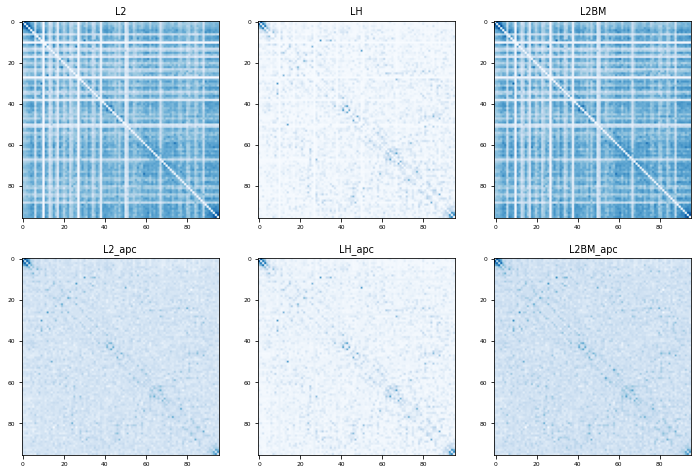

In [ ]:
raw_L2,apc_L2 = get_mtx(W_L2)
raw_LH,apc_LH = get_mtx(W_LH)
raw_L2BM,apc_L2BM = get_mtx(W_L2BM)
plt.figure(figsize=(12,8),facecolor="white")
plt.subplot(2,3,1); plt.imshow(raw_L2,cmap="Blues");plt.title("L2")
plt.subplot(2,3,4); plt.imshow(apc_L2,cmap="Blues");plt.title("L2_apc")
plt.subplot(2,3,2); plt.imshow(raw_LH,cmap="Blues");plt.title("LH")
plt.subplot(2,3,5); plt.imshow(apc_LH,cmap="Blues");plt.title("LH_apc")
plt.subplot(2,3,3); plt.imshow(raw_L2BM,cmap="Blues");plt.title("L2BM")
plt.subplot(2,3,6); plt.imshow(apc_L2BM,cmap="Blues");plt.title("L2BM_apc")

plt.savefig("/content/resample_MI.pdf")

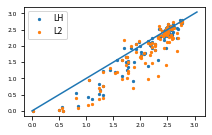

In [ ]:
plt.figure(figsize=(3.25,2))
train_entropy = np.sum(-train_pssm * np.log(train_pssm +1e-8),1)
LH_entropy = np.sum(-LH_pssm * np.log(LH_pssm +1e-8),1)
L2BM_entropy = np.sum(-L2BM_pssm * np.log(L2BM_pssm +1e-8),1)
L2_entropy = np.sum(-L2_pssm * np.log(L2_pssm +1e-8),1)
plt.scatter(train_entropy,LH_entropy,label="LH",s=5)
plt.scatter(train_entropy,L2_entropy,label="L2",s=5)
#plt.scatter(train_entropy,L2BM_entropy,label="L2BM",s=5)

plt.plot([0,np.log(21)],[0,np.log(21)])
plt.legend()

In [ ]:
print(np.corrcoef(train_entropy,LH_entropy)[0,1],np.corrcoef(train_entropy,L2_entropy)[0,1])


0.9532531222955787 0.9111696377226405


### clustering

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
return_H = True
Generate_Hamiltonian_L2 = get_Hamiltonian_loss(msa_gen_L2,W_L2,V_L2,return_H=return_H)
Generate_Hamiltonian_LH = get_Hamiltonian_loss(msa_gen_LH,W_LH,V_LH,return_H=return_H)
Generate_Hamiltonian_L2BM = get_Hamiltonian_loss(msa_gen_L2BM,W_L2BM,V_L2BM,return_H=return_H)

In [ ]:
 _,msa_L2BM_paper = mk_msa(sample_dict["0.33"][0])

In [ ]:
msa_flat = msa_nature.reshape(msa_nature.shape[0],-1)


In [ ]:
PCA_model = PCA(50).fit(msa_flat)

In [ ]:
msa_L2_flat = msa_gen_L2.reshape(msa_gen_L2.shape[0],-1)
msa_LH_flat = msa_gen_LH.reshape(msa_gen_LH.shape[0],-1)
msa_L2BM_flat = msa_gen_L2BM.reshape(msa_gen_L2BM.shape[0],-1)
msa_L2BM_paper_flat = msa_L2BM_paper.reshape(msa_L2BM_paper.shape[0],-1)

In [ ]:
nature_lr = PCA_model.transform(msa_flat)
L2_lr = PCA_model.transform(msa_L2_flat)
LH_lr = PCA_model.transform(msa_LH_flat)
L2BM_lr = PCA_model.transform(msa_L2BM_flat)
L2BM_paper_lr = PCA_model.transform(msa_L2BM_paper_flat)

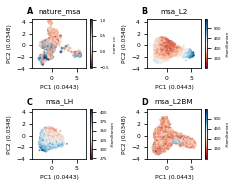

In [ ]:
x_range = [-4,7]
y_range = [-4,4.5]

fig = plt.figure(figsize=(3.25,3.25*0.8),facecolor="white")
gs = fig.add_gridspec(2, 2)
axes = [fig.add_subplot(gs[i]) for i in range(4)]

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=4) 
plt.rc('ytick', labelsize=4) 

fig.canvas.draw()

for n, ax in enumerate(axes):
  ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=8, weight='bold')
  

axes[0].set_title("nature_msa")
sc = axes[0].scatter(nature_lr[:,0],nature_lr[:,1],c=sample_dict["nature"][2],s=3,alpha=0.5,cmap="RdBu",rasterized=True)
axes[0].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[0].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

cb = fig.colorbar(sc, ax=axes[0])
cb.set_label(label=f"norm r.e.",size=4)

axes[1].set_title("msa_L2")
sc =  axes[1].scatter(L2_lr[:,0],L2_lr[:,1],c=-Generate_Hamiltonian_L2,s=1,alpha=0.5,cmap="RdBu",rasterized=True)

axes[1].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[1].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

cb = fig.colorbar(sc, ax=axes[1])
cb.set_label(label=f"-Hamiltonian",size=4)

axes[2].set_title("msa_LH")
sc = axes[2].scatter(LH_lr[:,0],LH_lr[:,1],c=-Generate_Hamiltonian_LH,s=1,alpha=0.5,cmap="RdBu",rasterized=True)
axes[2].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[2].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)
cb = fig.colorbar(sc, ax=axes[2])
cb.set_label(label=f"-Hamiltonian",size=4)

axes[3].set_title("msa_L2BM")
sc = axes[3].scatter(L2BM_lr[:,0],L2BM_lr[:,1],c=-Generate_Hamiltonian_L2,s=1,alpha=0.5,cmap="RdBu",rasterized=True)
axes[3].set_xlabel(f"PC1 ({PCA_model.explained_variance_ratio_[0]:.3})",size=6)
axes[3].set_ylabel(f"PC2 ({PCA_model.explained_variance_ratio_[1]:.3})",size=6)
axes[3].set_xlim(x_range)
axes[3].set_ylim(y_range)
cb = fig.colorbar(sc, ax=axes[3])
cb.set_label(label=f"-Hamiltonian",size=4)

plt.tight_layout()
plt.savefig("/content/sequence_PCA.pdf")


### Interpretability

In [ ]:
# !wget -q -nc http://www.structpred.club/~cybertruck/science_evolution/ASC.fas
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/ADKMLBay_3.fasta
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/Adk_201602.fas
!wget -q -nc https://files.rcsb.org/download/1P3J.pdb
!wget -q -nc http://www.structpred.club/~cybertruck/LH/applications/ASR/ADK_paper.fasta

#### parse data

In [ ]:
# get MSA
_,seqs = parse_fasta('Adk_201602.fas')
# seqs = parse_aln('subtilis.aln')
seqs = seqs[:-1]
msa_ori,msa = mk_msa(seqs[1:])
seq = seqs[0]
L = len(seq)
print(msa.shape)

# get sequences
heads,prots_ASR = parse_fasta('ADKMLBay_3.fasta')
prots_ASR = prots_ASR[:-2]
heads = heads[:-2]
infos = [head.split() for head in heads]

# get temperature
temperature = []
for ith, prot in enumerate(prots_ASR):
  temperature.append(float(infos[ith][1]))

# get activity
activity = []
for ith, prot in enumerate(prots_ASR):
  activity.append(float(infos[ith][2]))

# delete some proteins
idx = []
opening = []
for ith, prot in enumerate(prots_ASR):
  if infos[ith][3] == 'NA':
    idx.append(ith)
  else:
    opening.append(float(infos[ith][3]))

sel = set(range(len(prots_ASR)))
sel = list(sel - set(idx))
prots_ASR = [prots_ASR[isel] for isel in sel]
infos = [infos[isel] for isel in sel]
temperature = [temperature[isel] for isel in sel]
activity = [activity[isel] for isel in sel]

(9943, 217, 21)


In [ ]:
_,paper_seqs = parse_fasta('ADK_paper.fasta')
# seqs = parse_aln('subtilis.aln')
new_paper_seqs = []
for seq in paper_seqs:
  new_paper_seqs.append(seq[2:157] + '-' + seq[159:] + '-'*5)
msa_ori_paper,msa_paper = mk_msa(new_paper_seqs)

In [ ]:
_,prots_msa = mk_msa(prots_ASR)

In [ ]:
# train the model
V_L2,W_L2 = GREMLIN(msa_ori,opt_iter=500,reg_mode="L2",param_flag=True)
V_LH,W_LH = GREMLIN(msa_ori,opt_iter=500,reg_mode="LH",lambda_LH=0.5,param_flag=True)
V_LB,W_LB = GREMLIN(msa_ori,opt_iter=500,reg_mode="LB",param_flag=True)

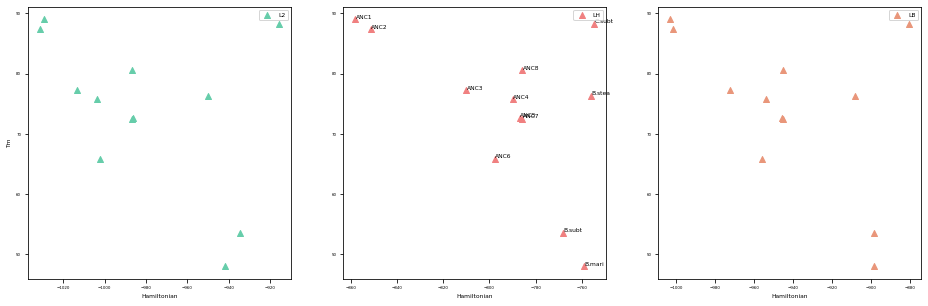

In [ ]:

prot_H_LH = get_Hamiltonian_loss(prots_msa,W_LH,V_LH,return_H=True)

prot_H_L2 = get_Hamiltonian_loss(prots_msa,W_L2,V_L2,return_H=True)

prot_H_LB = get_Hamiltonian_loss(prots_msa,W_LB,V_LB,return_H=True)

plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.scatter(prot_H_L2, temperature, marker = "^", c='mediumaquamarine', label='L2')
#for i in range(len(infos)):
 # plt.annotate(infos[i][0][:6], xy=(prot_H_L2[i], temperature[i]), xytext=(prot_H_L2[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");plt.ylabel("Tm");plt.legend()


plt.subplot(132)
plt.scatter(prot_H_LH, temperature, marker = "^", c='lightcoral', label='LH')
for i in range(len(infos)):
  plt.annotate(infos[i][0][:6], xy=(prot_H_LH[i], temperature[i]), xytext=(prot_H_LH[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");#plt.ylabel("Tm");
plt.legend()

plt.subplot(133)
plt.scatter(prot_H_LB, temperature, marker = "^", c='darksalmon', label='LB')
#for i in range(len(infos)):
 # plt.annotate(infos[i][0][:6], xy=(prot_H_LN[i], temperature[i]), xytext=(prot_H_LN[i]+0.1, temperature[i]+0.1))
plt.xlabel("Hamiltonian");#plt.ylabel("Tm");
plt.legend()
plt.savefig("/content/ADK_Tm.pdf")

In [ ]:
def get_sin_contact(prot, W,V=None):
  a2n = {a:n for n,a in enumerate(alphabet)}
  prot_oh = np.array([a2n.get(aa, len(alphabet)-1) for aa in prot])
  prot_oh = np.eye(21)[prot_oh]
  prot_mask = np.einsum("ij,kl->ijkl",prot_oh,prot_oh)
  return np.sum(prot_mask*W,(1,3))

In [ ]:
# B.subtilis
contact_B = get_sin_contact(prots_ASR[0], W_LH)
# ANC1
contact_1 = get_sin_contact(prots_ASR[9], W_LH)

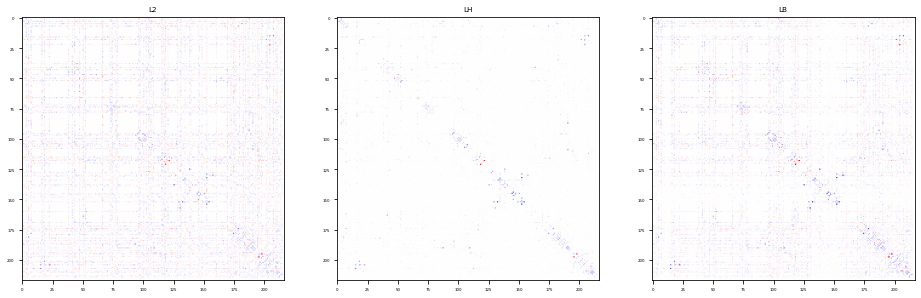

In [ ]:
plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.title("L2")
contact_Bs = get_sin_contact(prots_ASR[0], W_L2)
contact_AN1 = get_sin_contact(prots_ASR[9], W_L2)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)

plt.subplot(132)
plt.title("LH")
contact_Bs = get_sin_contact(prots_ASR[0], W_LH)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LH)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)

plt.subplot(133)
plt.title("LB")
contact_Bs = get_sin_contact(prots_ASR[0], W_LB)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LB)
plt.imshow(contact_Bs - contact_AN1, cmap="bwr",vmin=-0.8,vmax=0.8)
plt.savefig("/content/ADK_delta_contacts.pdf")

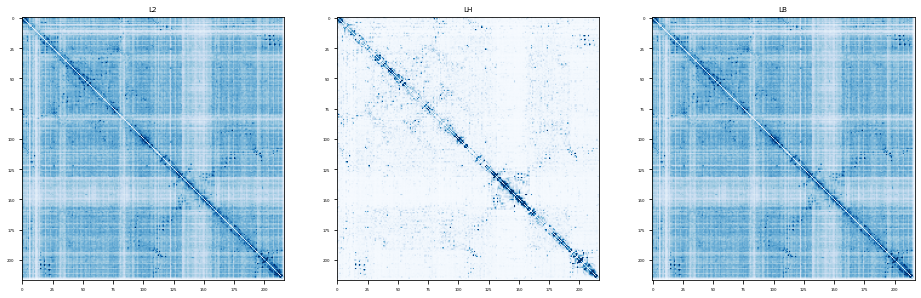

In [ ]:
plt.figure(figsize=[16,5],facecolor="white")

plt.subplot(131)
plt.title("L2")
plt.imshow(get_mtx(W_L2)[0], cmap="Blues",vmin=0,vmax=0.8)

plt.subplot(132)
plt.title("LH")
plt.imshow(get_mtx(W_LH)[0], cmap="Blues",vmin=0,vmax=0.8)

plt.subplot(133)
plt.title("LB")
contact_Bs = get_sin_contact(prots_ASR[0], W_LB)
contact_AN1 = get_sin_contact(prots_ASR[9], W_LB)
plt.imshow(get_mtx(W_L2)[0], cmap="Blues",vmin=0,vmax=0.8)
